# Cardiovascular Disease Prediction - CRISP 01

## What are cardiovascular diseases?

Cardiovascular diseases (CVDs) are a group of disorders of the heart and blood vessels and they include:

 - coronary heart disease – disease of the blood vessels supplying the heart muscle;
 - cerebrovascular disease – disease of the blood vessels supplying the brain;
 - peripheral arterial disease – disease of blood vessels supplying the arms and legs;
 - rheumatic heart disease – damage to the heart muscle and heart valves from rheumatic fever, caused by streptococcal bacteria;
 - congenital heart disease – malformations of heart structure existing at birth;
 - deep vein thrombosis and pulmonary embolism – blood clots in the leg veins, which can dislodge and move to the heart and lungs.

Heart attacks and strokes are usually acute events and are mainly caused by a blockage that prevents blood from flowing to the heart or brain. The most common reason for this is a build-up of fatty deposits on the inner walls of the blood vessels that supply the heart or brain. Strokes can also be caused by bleeding from a blood vessel in the brain or from blood clots. The cause of heart attacks and strokes are usually the presence of a combination of risk factors, such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol, hypertension, diabetes and hyperlipidaemia.


### Key facts

 - CVDs are the number 1 cause of death globally: more people die annually from CVDs than from any other cause.
 - An estimated 17.9 million people died from CVDs in 2016, representing 31% of all global deaths. Of these deaths, 85% are due to heart attack and stroke.
 - Over three quarters of CVD deaths take place in low- and middle-income countries.
 - Out of the 17 million premature deaths (under the age of 70) due to noncommunicable diseases in 2015, 82% are in low- and middle-income countries, and 37% are caused by CVDs.
 - Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.
 - People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management using counselling and medicines, as appropriate.
  

## What are the risk factors for cardiovascular disease?

The most important behavioural risk factors of heart disease and stroke are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects of behavioural risk factors may show up in individuals as raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity. These “intermediate risks factors” can be measured in primary care facilities and indicate an increased risk of developing a heart attack, stroke, heart failure and other complications.

Cessation of tobacco use, reduction of salt in the diet, consuming fruits and vegetables, regular physical activity and avoiding harmful use of alcohol have been shown to reduce the risk of cardiovascular disease. In addition, drug treatment of diabetes, hypertension and high blood lipids may be necessary to reduce cardiovascular risk and prevent heart attacks and strokes. Health policies that create conducive environments for making healthy choices affordable and available are essential for motivating people to adopt and sustain healthy behaviour.

There are also a number of underlying determinants of CVDs or "the causes of the causes". These are a reflection of the major forces driving social, economic and cultural change – globalization, urbanization and population ageing. Other determinants of CVDs include poverty, stress and hereditary factors.

# 0.0 Imports

In [115]:
# Data Manipulation
import numpy as np
import pandas as pd

# Exploratory Data Analyses
import seaborn as sns
import statistics as st
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Feature Selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Machine Learning
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

# Model Evaluation
from scipy import stats as ss
from sklearn.metrics import mean_absolute_error, mean_squared_error

# API
import json
import pickle
import requests
import warnings
import random as rnd

# Display
from IPython.core.display import HTML
from IPython.display import Image

# Filter Warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [116]:
# Descripite Statistics of a Data Frame
def descriptive( df ):
    # Central Tendency - mean, median, mode 
    ct1 = pd.DataFrame( df.apply( np.mean) ).T
    ct2 = pd.DataFrame( df.apply( np.median) ).T
    ct3 = pd.DataFrame( df.apply( st.mode ) ).T 
    
    # Dispersion
    d1 = pd.DataFrame( df.apply( np.std) ).T
    d2 = pd.DataFrame( df.apply( min) ).T
    d3 = pd.DataFrame( df.apply( max) ).T
    d4 = pd.DataFrame( df.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( df.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( df.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate
    ds = pd.concat([ct1, ct2, ct3, d1, d2, d3, d4, d5, d6]).T.reset_index()
    ds.columns = ['attributes', 'mean', 'median', 'mode', 'std', 'min', 'max', 'range', 'skewness', 'kurtosis']
    return ds

# Quantiles of Boxplot
def boxqt(df):
    Q0 = np.quantile(df, .0)
    Q1 = np.quantile(df, .25)
    Q2 = np.quantile(df, .50)
    Q3 = np.quantile(df, .75)
    Q4 = np.quantile(df, 1.0)
    return print('Q0 is {}\nQ1 is {}\nQ2 is {}\nQ3 is {}\nQ4 is {}'.format(Q0, Q1, Q2, Q3, Q4))

# Jupyter Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 25
    
    #display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.despine( bottom = True, left = True)
    sns.set()

In [117]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


<Figure size 1800x864 with 0 Axes>

# 1.0 Data Description

## 1.1 Understanding Variables

There are 3 types of input features:

    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.
   
Features:

  - Age | Objective Feature | age | int (days)
  - Height | Objective Feature | height | int (cm) |
  - Weight | Objective Feature | weight | float (kg) |
  - Gender | Objective Feature | gender | categorical code | 1- women | 2 -men
  - Systolic blood pressure | Examination Feature | ap_hi | int |
  - Diastolic blood pressure | Examination Feature | ap_lo | int |
  - Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
  - Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
  - Smoking | Subjective Feature | smoke | binary |
  - Alcohol intake | Subjective Feature | alco | binary |
  - Physical activity | Subjective Feature | active | binary |
  - Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

## Understanding Blood Pressure, Cholesterol and Glycemia Levels 

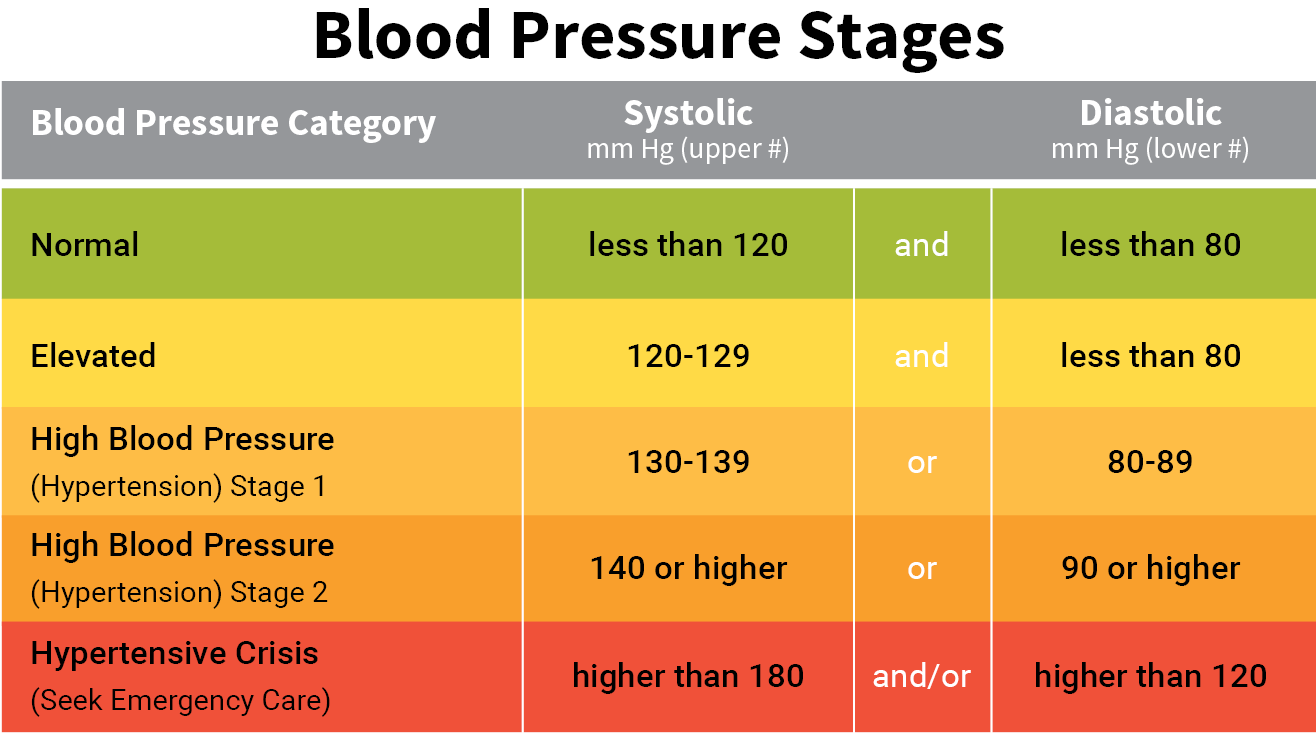

In [118]:
Image('img/blood_presure.png')

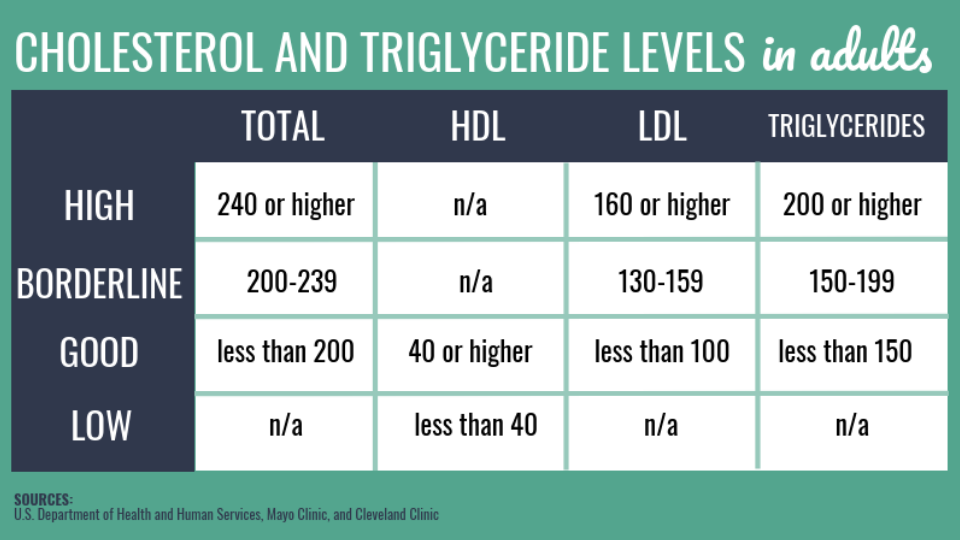

In [119]:
Image('img/cholesterol.png')

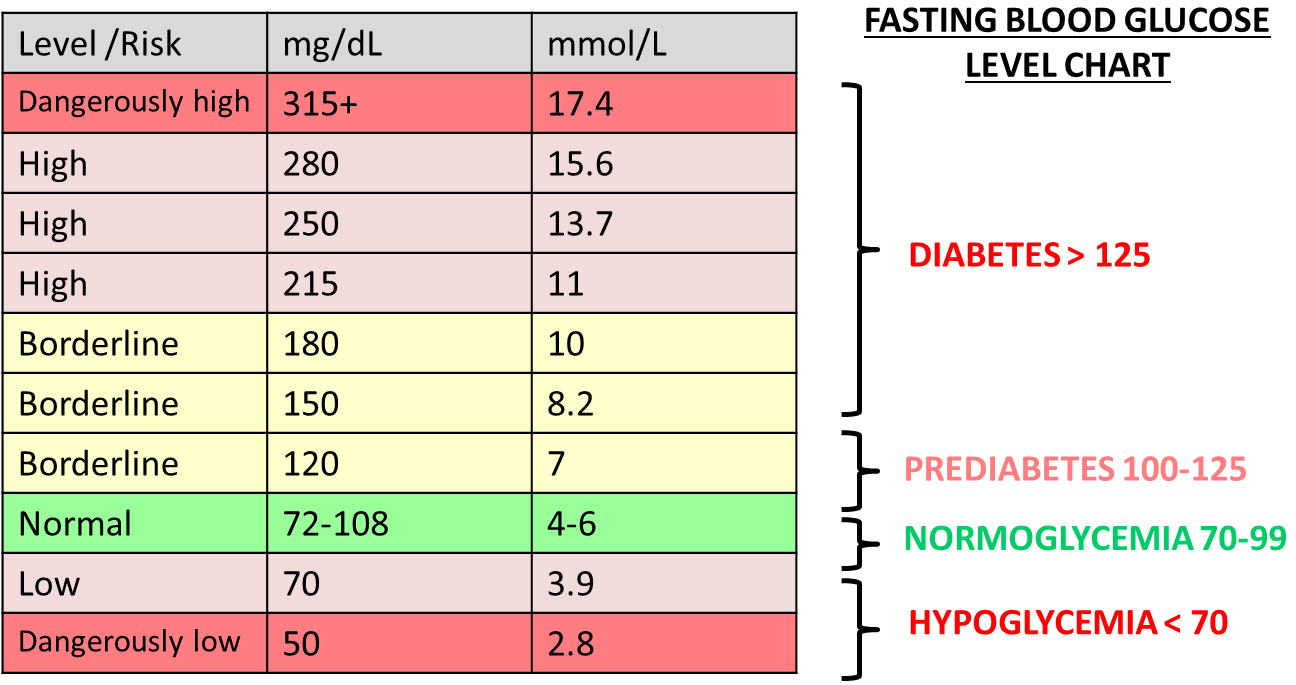

In [120]:
Image('img/glucose.png')

## 1.2 Loading Data

In [121]:
df1 = pd.read_csv('cardio_train.csv', sep=';', low_memory=False)
df1.head().T

,0,1,2,3,4
id,0.0,1.0,2.0,3.0,4.0
age,18393.0,20228.0,18857.0,17623.0,17474.0
gender,2.0,1.0,1.0,2.0,1.0
height,168.0,156.0,165.0,169.0,156.0
weight,62.0,85.0,64.0,82.0,56.0
ap_hi,110.0,140.0,130.0,150.0,100.0
ap_lo,80.0,90.0,70.0,100.0,60.0
cholesterol,1.0,3.0,3.0,1.0,1.0
gluc,1.0,1.0,1.0,1.0,1.0
smoke,0.0,0.0,0.0,0.0,0.0


## 1.3 Data Dimensions

In [122]:
# Number of Rows and Columns
print('Number of Rows', df1.shape[0])
print('Number of Columns', df1.shape[1])

Number of Rows 70000
Number of Columns 13


## 1.4 Data Info

In [123]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## 1.5 Age Convert

In [124]:
# Convert age days in years
df1['age'] = df1['age'] / 365

# Convert do interger 
df1['age'] = df1['age'].astype(int)
df1.head().T

,0,1,2,3,4
id,0.0,1.0,2.0,3.0,4.0
age,50.0,55.0,51.0,48.0,47.0
gender,2.0,1.0,1.0,2.0,1.0
height,168.0,156.0,165.0,169.0,156.0
weight,62.0,85.0,64.0,82.0,56.0
ap_hi,110.0,140.0,130.0,150.0,100.0
ap_lo,80.0,90.0,70.0,100.0,60.0
cholesterol,1.0,3.0,3.0,1.0,1.0
gluc,1.0,1.0,1.0,1.0,1.0
smoke,0.0,0.0,0.0,0.0,0.0


In [125]:
# Verification
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int32  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int32(1), int64(11)
memory usage: 6.7 MB


## 1.6 Descriptive Statistics

In [126]:
descriptive(df1)

,attributes,mean,median,mode,std,min,max,range,skewness,kurtosis
0,id,49972.419900,50001.5,0.0,28851.096242,0.0,99999.0,99999.0,-0.001278,-1.198374
1,age,52.840671,53.0,55.0,6.766725,29.0,64.0,35.0,-0.305744,-0.818981
2,gender,1.349571,1.0,1.0,0.476835,1.0,2.0,1.0,0.630960,-1.601935
3,height,164.359229,165.0,165.0,8.210068,55.0,250.0,195.0,-0.642187,7.943653
4,weight,74.205690,72.0,65.0,14.395654,10.0,200.0,190.0,1.012070,2.586825
5,ap_hi,128.817286,120.0,120.0,154.010319,-150.0,16020.0,16170.0,85.296214,7580.074738
6,ap_lo,96.630414,80.0,80.0,188.471184,-70.0,11000.0,11070.0,32.114083,1425.914585
7,cholesterol,1.366871,1.0,1.0,0.680245,1.0,3.0,2.0,1.587123,0.993901
8,gluc,1.226457,1.0,1.0,0.572266,1.0,3.0,2.0,2.397462,4.294377
9,smoke,0.088129,0.0,0.0,0.283482,0.0,1.0,1.0,2.905867,6.444250


### Keys points:

#### - The mean age is 55 years, ranging from 29 to 64

#### - There are more women than men in the dataset

#### - Glucose and cholesterol levels in most people are normal

#### - Most people do not smoke, drink alcohol and exercise.

#### - Some numerical variables have outliers based on their skewness

   - Height - negative moderately skewed
   - Weight - positive moderated skewed
   - ap_hi, ap_lo - positive high skewed

## 1.7 Outliers

### 1.7.1 Boxplots  with outliers

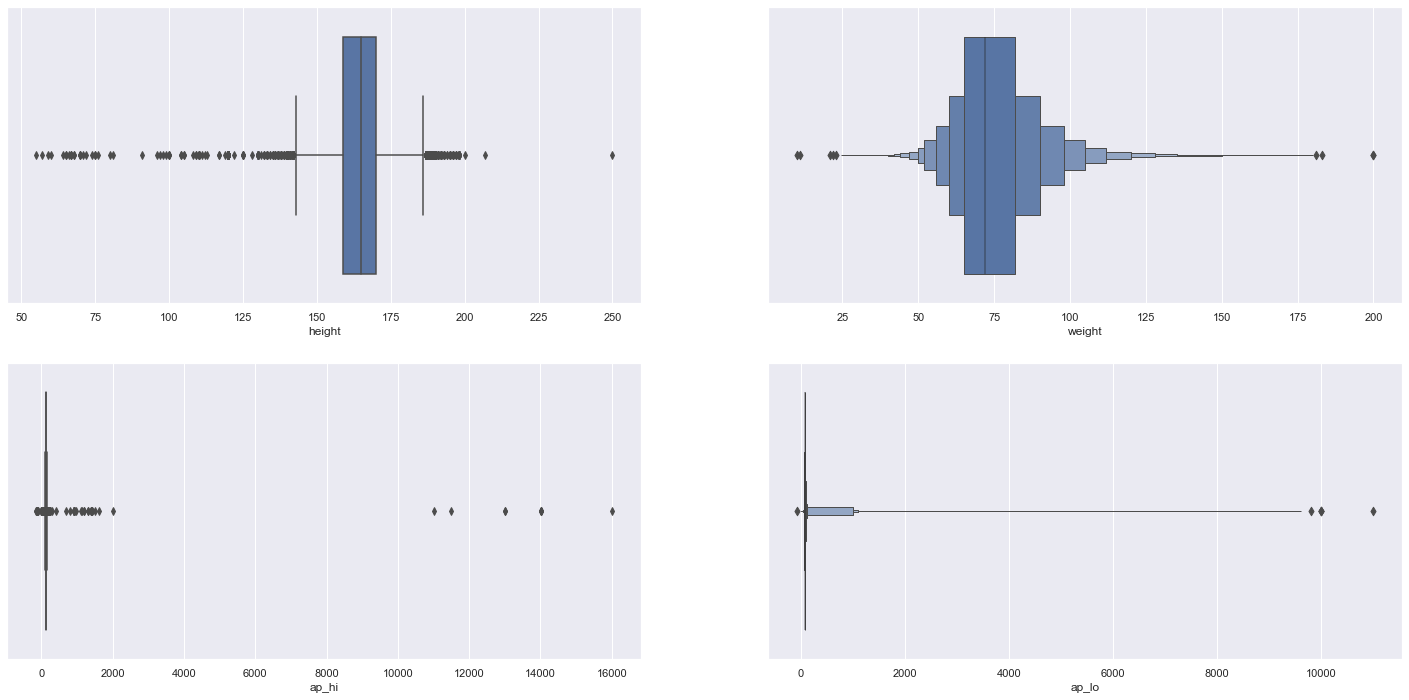

In [127]:
# Boxplot of height
plt.subplot(2,2,1)
sns.boxplot(df1['height'])

# Boxplot of weight
plt.subplot(2,2,2)
sns.boxenplot(df1['weight'])

# Boxplot of ap_hi
plt.subplot(2,2,3)
sns.boxplot(df1['ap_hi'])

# Boxplot of ap_lo
plt.subplot(2,2,4) 
sns.boxenplot(df1['ap_lo']);

### 1.7.2 Boxplots Without Outliers

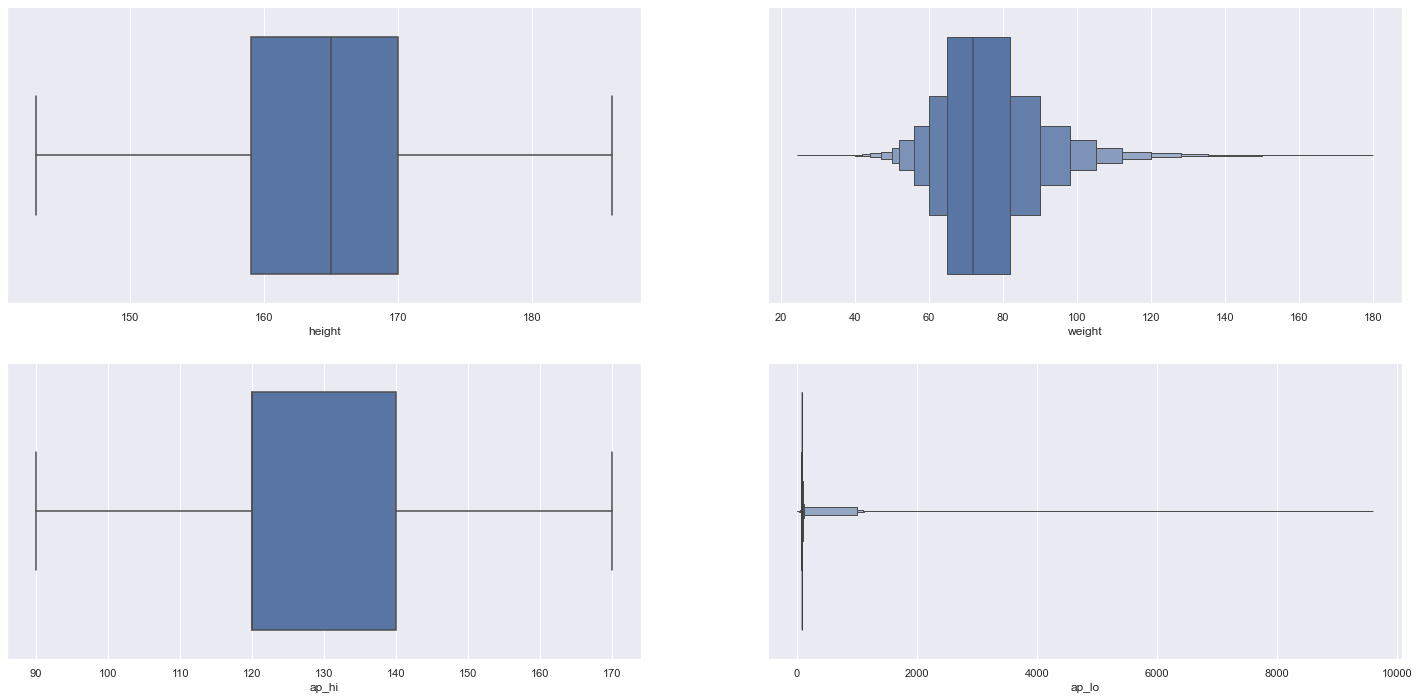

In [128]:
# Boxplot of height
plt.subplot(221)
sns.boxplot(df1['height'], showfliers = False)

# Boxplot of weight
plt.subplot(222)
sns.boxenplot(df1['weight'], showfliers = False)

# Boxplot of ap_hi
plt.subplot(223)
sns.boxplot(df1['ap_hi'], showfliers = False)

# Boxplot of ap_lo
plt.subplot(224) 
sns.boxenplot(df1['ap_lo'], showfliers = False);

#### To clarify the divisions of each boxplot it was calculated the quartiles of each variable.

In [129]:
# Height
boxqt(df1['height'])

Q0 is 55.0
Q1 is 159.0
Q2 is 165.0
Q3 is 170.0
Q4 is 250.0


In [130]:
# Weight
boxqt(df1['weight'])

Q0 is 10.0
Q1 is 65.0
Q2 is 72.0
Q3 is 82.0
Q4 is 200.0


In [131]:
# ap_hi
boxqt(df1['ap_hi'])

Q0 is -150.0
Q1 is 120.0
Q2 is 120.0
Q3 is 140.0
Q4 is 16020.0


In [132]:
# ap_lo
boxqt(df1['ap_lo'])

Q0 is -70.0
Q1 is 80.0
Q2 is 80.0
Q3 is 90.0
Q4 is 11000.0


### 1.7.3 Understanding Individual cases

#### The chart below can be used as a guide to help decide what can be done with outliers

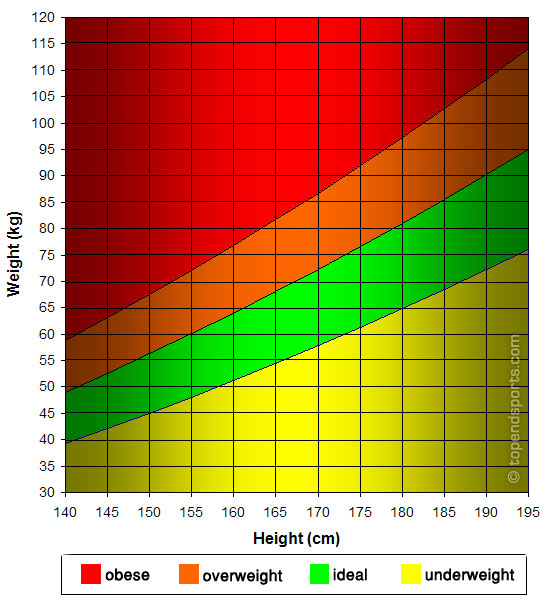

In [133]:
Image("img/wxh.jpg")

#### 1.7.3.1 Height

In [134]:
aux = df1.sort_values(by=['height'], ascending=False).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6486,9223,58,1,250,86.0,140,100,3,1,0,0,1,1
21628,30894,52,2,207,78.0,100,70,1,1,0,1,1,0
41901,59847,52,2,200,100.0,170,1100,2,2,0,0,1,1
8897,12687,61,2,198,79.0,160,100,1,1,1,0,0,1
30127,43083,63,1,198,85.0,110,90,1,1,0,0,1,0
1117,1554,60,2,198,68.0,120,80,1,1,0,0,1,1
57529,82105,51,2,198,78.0,120,80,1,1,1,0,1,1
54289,77425,58,2,198,110.0,140,80,2,3,0,0,1,1
66145,94422,61,1,198,80.0,140,90,1,2,0,0,1,1
3237,4561,44,2,198,61.0,110,70,1,1,0,0,1,1


Based on the literature it is unlikely that someone with gigantism and a height of 2,50 m. The other cases can be acceptable (future review CRSIP-DS).

In [135]:
aux = df1.sort_values(by=['height'], ascending=True).head(40)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22723,32456,64,1,55,81.0,130,90,1,1,0,0,1,1
66643,95141,51,1,57,61.0,130,90,1,1,0,0,1,1
64115,91523,50,1,59,57.6,125,67,1,1,0,0,0,0
29157,41661,52,1,60,69.0,110,70,1,1,0,0,0,0
27603,39462,57,1,64,61.0,130,70,1,1,0,0,1,0
44490,63545,52,1,65,60.0,120,80,1,1,0,0,1,0
33607,48009,53,2,65,72.0,130,80,1,1,0,0,0,0
64454,92008,58,1,66,63.0,12,80,1,1,0,0,0,1
14323,20459,60,1,67,57.0,120,90,1,1,0,0,1,1
53344,76116,56,2,67,80.0,120,80,1,1,0,0,0,1


The smallest patients are the height of a child, but the age range is 29 to 64 years. Even people with dwarfism have a minimum average height range of 1,20m to 1,40 m.

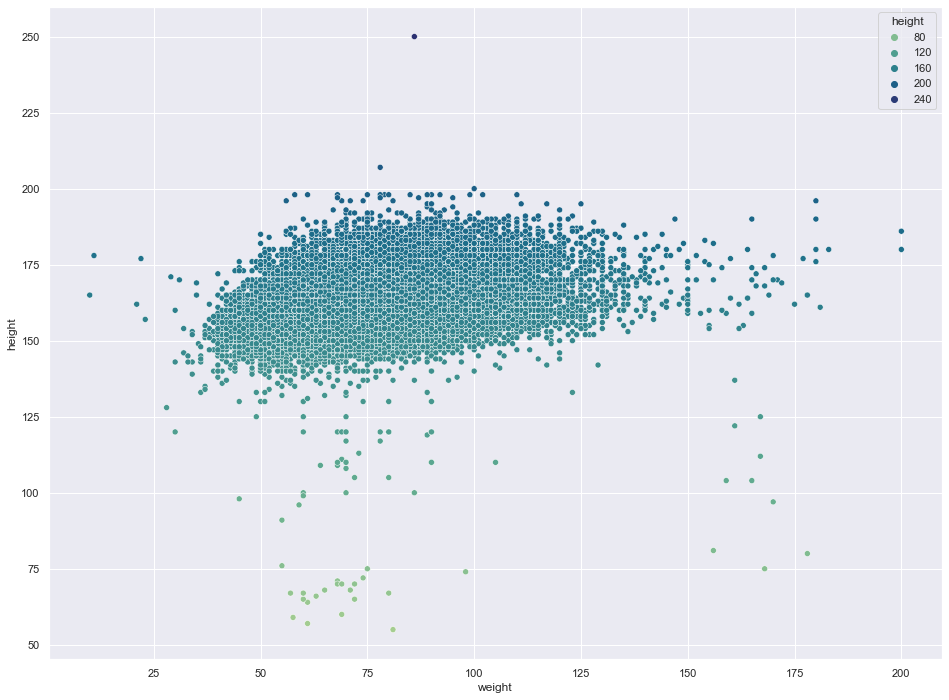

In [136]:
plt.figure(figsize = (16,12))
sns.scatterplot(data = df1, x = 'weight', y = 'height', hue='height', palette = 'crest');

The graph shows very unlikely cases. For instance, a person with a height of 75 cm and a weight of 170 Kg.

#### Based on previous analyzes, it was decided to change the patient with a height of 2,50 m and patients below 1,20 m by the average height.

In [137]:
# Calculate Height Mean
height_mean = df1['height'].mean()
height_mean

164.35922857142856

In [138]:
# Apply Mean to Height Outliers
df1['height'] = df1['height'].apply(lambda x: 164 if x > 210 or x < 120 else x)

#### 1.7.3.2 Weight

In [139]:
aux = df1.sort_values(by=['weight'], ascending=False).head(10)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
50413,71945,41,2,180,200.0,150,90,1,1,0,0,1,1
435,618,45,1,186,200.0,130,70,1,1,0,0,0,0
61285,87498,57,2,180,183.0,110,80,3,3,0,1,1,1
36780,52564,53,1,161,181.0,180,1100,2,1,0,0,1,1
60592,86506,51,2,180,180.0,140,100,3,1,0,0,1,1
4743,6716,47,2,176,180.0,140,90,1,1,0,0,1,1
45378,64829,47,2,190,180.0,140,80,2,2,0,0,1,1
61362,87612,45,2,196,180.0,130,80,3,1,0,0,1,1
20092,28683,56,2,165,178.0,120,80,1,1,1,1,1,0
61788,88220,51,2,165,178.0,120,80,1,1,0,0,1,0


Based on the literature it is possible for people to weigh 200kg. Future review (CRISP-DS)

In [140]:
aux = df1.sort_values(by=['weight'], ascending=True).head(15)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
57858,82567,51,2,165,10.0,180,1100,2,2,0,0,1,1
33817,48318,59,2,178,11.0,130,90,1,1,0,0,1,1
60188,85931,59,1,162,21.0,120,80,2,1,0,0,1,1
29488,42156,55,2,177,22.0,120,80,1,1,1,1,1,0
26806,38312,63,1,157,23.0,110,80,1,1,0,0,1,0
34276,48976,40,2,128,28.0,120,80,1,1,0,0,1,0
60699,86650,51,1,171,29.0,110,70,2,1,0,0,1,1
41905,59853,58,1,143,30.0,103,61,2,1,0,0,1,0
3752,5306,42,1,120,30.0,110,70,1,1,0,0,1,0
18559,26503,49,1,160,30.0,120,80,1,1,0,0,1,1


Based on the literature it is unlikely for some people to weigh above 40kg. Future review (CRISP-DS)

#### Based on the previous analyses it was decided to change weights above 40kg by the mean.

In [141]:
# Calculate weight Mean
weight_mean = df1['weight'].mean()
weight_mean

74.20569

In [142]:
# Apply Mean to Weight Outliers
df1['weight'] = df1['weight'].apply(lambda x: 74 if x < 40 else x)

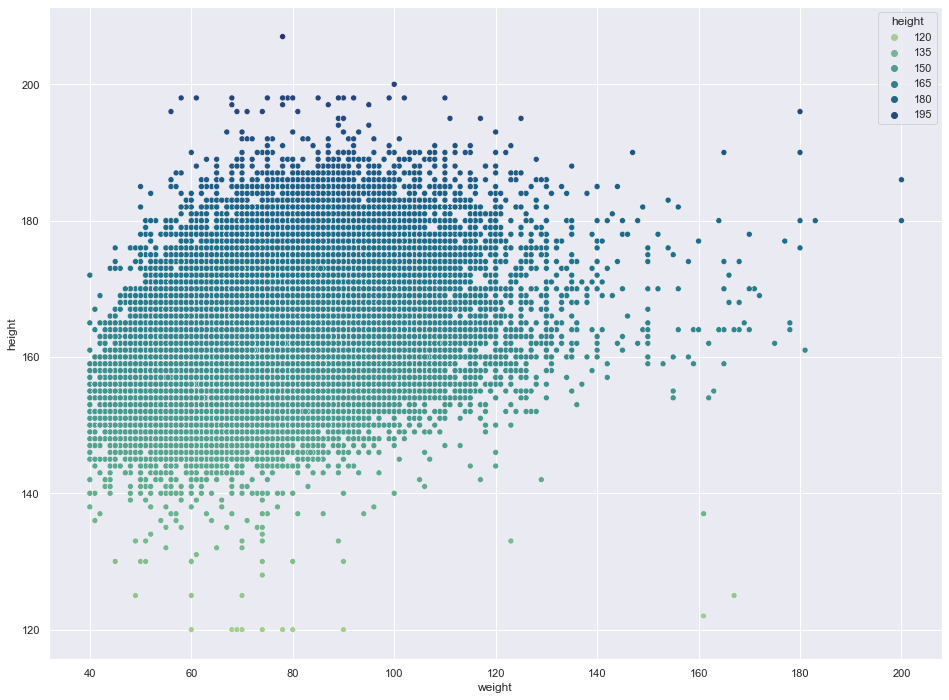

In [143]:
# Scatterplot after weight and height outliers treatment
plt.figure(figsize = (16,12))
sns.scatterplot(data = df1, x = 'weight', y = 'height', hue='height', palette = 'crest');

Analyzing the graph again the cuts that were made are noticeable, but it seems to be much more reasonable now. 

#### 1.7.3.3 ap_lo (Diastolic Blood Presure)

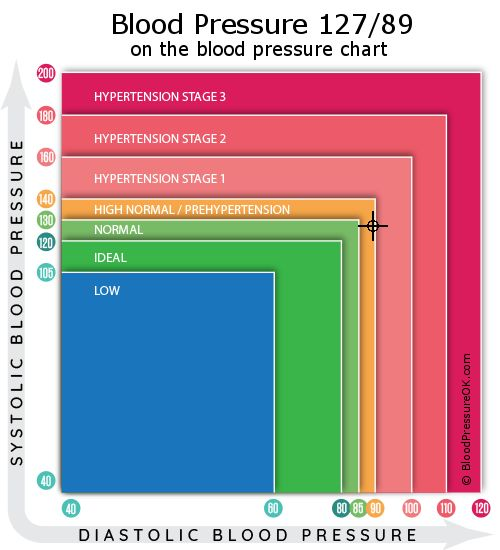

In [144]:
Image('img/bloodpresure.jpg')

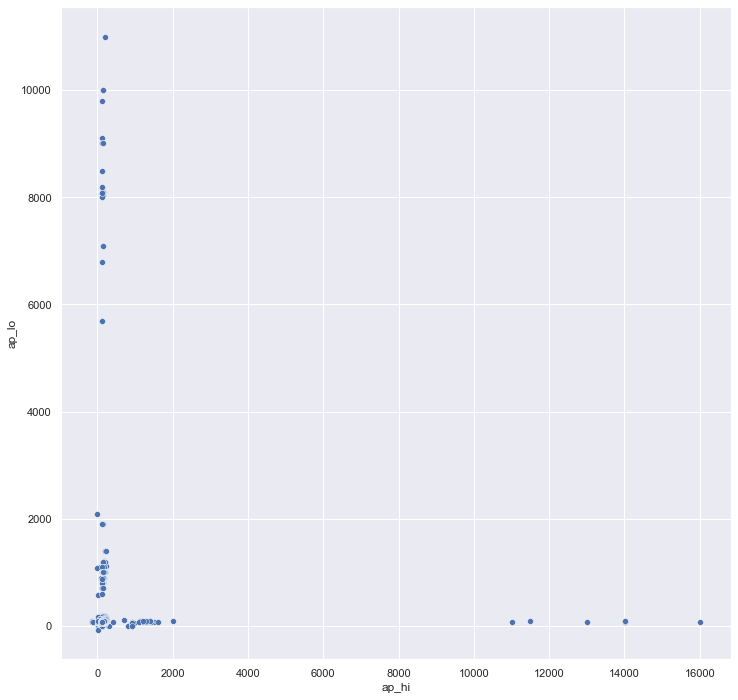

In [145]:
# Scatterplot of ap_li and ap_lo 
plt.figure(figsize = (12,12))
sns.scatterplot(data = df1, x = 'ap_hi', y = 'ap_lo');

In [146]:
aux = df1.sort_values(by=['ap_lo'], ascending=False).head(15)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
43326,61901,63,1,160,105.0,200,11000,1,1,0,0,1,1
68538,97907,52,1,166,70.0,160,10000,2,1,0,0,1,1
2381,3352,57,2,186,105.0,140,10000,1,1,0,0,1,1
23849,34098,49,2,169,86.0,150,10000,2,2,0,1,1,1
43434,62058,60,2,179,62.0,130,9800,1,1,0,0,1,0
6653,9482,53,1,162,69.0,130,9100,1,1,0,0,1,1
32920,47030,50,1,156,65.0,150,9011,2,2,0,0,1,1
12086,17260,58,2,169,78.0,130,9011,1,1,1,1,1,1
15990,22832,39,2,179,70.0,120,8500,1,1,0,0,1,0
44042,62921,58,1,165,74.0,120,8200,2,3,0,0,1,0


As can be seen many patients have impossible number for blood pressure 

In [147]:
aux = df1.sort_values(by=['ap_lo'], ascending=True).head(15)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,85816,61,1,167,74.0,15,-70,1,1,0,0,1,1
40330,57646,55,1,162,50.0,309,0,1,1,0,0,1,0
42397,60565,49,2,176,69.0,906,0,1,1,0,0,1,0
56950,81298,41,1,164,70.0,120,0,1,1,0,0,1,0
63787,91073,40,2,161,61.0,117,0,1,1,0,0,1,0
52580,75007,60,1,155,66.0,13,0,1,1,0,0,1,0
17381,24837,49,1,164,78.0,138,0,1,1,0,0,1,0
41505,59301,57,1,154,41.0,806,0,1,1,0,0,1,0
31783,45400,44,1,170,64.0,907,0,1,1,0,0,1,0
2014,2845,62,2,167,59.0,906,0,1,1,0,0,1,0


The same can be seen here

#### Based on the literature it was decided to substitute the values higher than 120 and lower than 40 by the median (the median was chosen because the amount of outliers is big)

In [148]:
# Calculate ap_lo median
ap_lo_median = df1['ap_lo'].median()
ap_lo_median

80.0

In [149]:
# Apply Mean to ap_lo Outliers
df1['ap_lo'] = df1['ap_lo'].apply(lambda x: 80 if x > 120 or x < 40 else x)

#### 1.7.3.4 ap_hi (Systolic Blood Presure)

In [150]:
aux = df1.sort_values(by=['ap_hi'], ascending=False).head(15)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
40852,58374,47,1,169,70.0,16020,80,1,1,0,0,0,1
46912,66998,46,2,180,78.0,14020,90,1,1,0,0,1,1
25519,36414,58,1,169,71.0,14020,80,3,3,0,0,1,1
25464,36339,43,2,169,75.0,14020,80,2,1,0,0,1,1
47253,67502,54,1,160,65.0,14020,90,1,1,0,0,1,0
55847,79679,63,1,161,105.0,13010,80,1,1,0,0,0,0
55459,79116,50,1,152,76.0,13010,80,2,2,0,0,1,1
7763,11089,57,1,175,80.0,11500,90,1,1,0,0,1,1
51438,73356,51,2,168,65.0,11020,80,1,1,0,0,1,1
69370,99089,40,1,170,74.0,2000,100,2,1,0,0,1,1


The highest values are impossible numbers

In [151]:
aux = df1.sort_values(by=['ap_hi'], ascending=True).head(15)
aux

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
35040,50055,63,2,168,59.0,-150,80,1,1,0,0,1,1
23988,34295,50,1,162,74.0,-140,90,1,1,0,0,1,1
46627,66571,64,2,160,59.0,-120,80,1,1,0,0,0,0
25240,36025,40,2,168,50.0,-120,80,2,1,0,0,0,1
16021,22881,60,2,161,90.0,-115,70,1,1,0,0,1,0
20536,29313,42,1,153,54.0,-100,70,1,1,0,0,1,0
4607,6525,41,1,165,78.0,-100,80,2,1,0,0,1,0
8757,12494,46,2,163,63.0,1,80,1,1,1,0,1,0
42334,60477,51,1,171,80.0,1,80,1,1,0,0,1,1
5382,7657,58,1,162,69.0,7,80,1,1,0,0,1,0


The lowest values are impossible numbers too

#### Based on the literature it was decided to substitute the values higher than 200 and lower than 40 by the median (the median was chosen because the amount of outliers is big)

In [152]:
# Calculate ap_lo median
ap_hi_median = df1['ap_hi'].median()
ap_hi_median

120.0

In [153]:
# Apply Mean to ap_lo Outliers
df1['ap_hi'] = df1['ap_hi'].apply(lambda x: 120 if x > 200 or x < 40 else x)

#### Scatter plot after processing

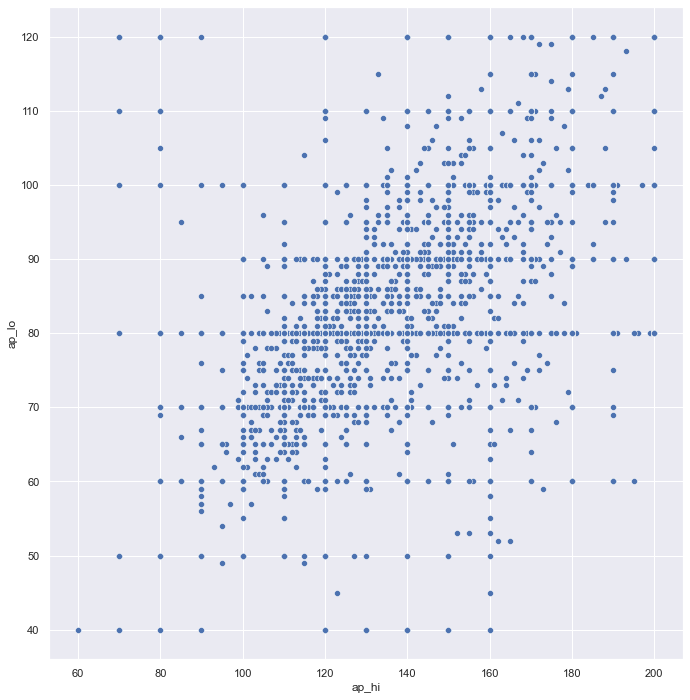

In [154]:
# Scatterplot of ap_li and ap_lo 
plt.subplot(121)
sns.scatterplot(data = df1, x = 'ap_hi', y = 'ap_lo');

The graph now is much more reasonable

# 2.0 Feature Engineering

## 2.1 Hypothesis Mental Map

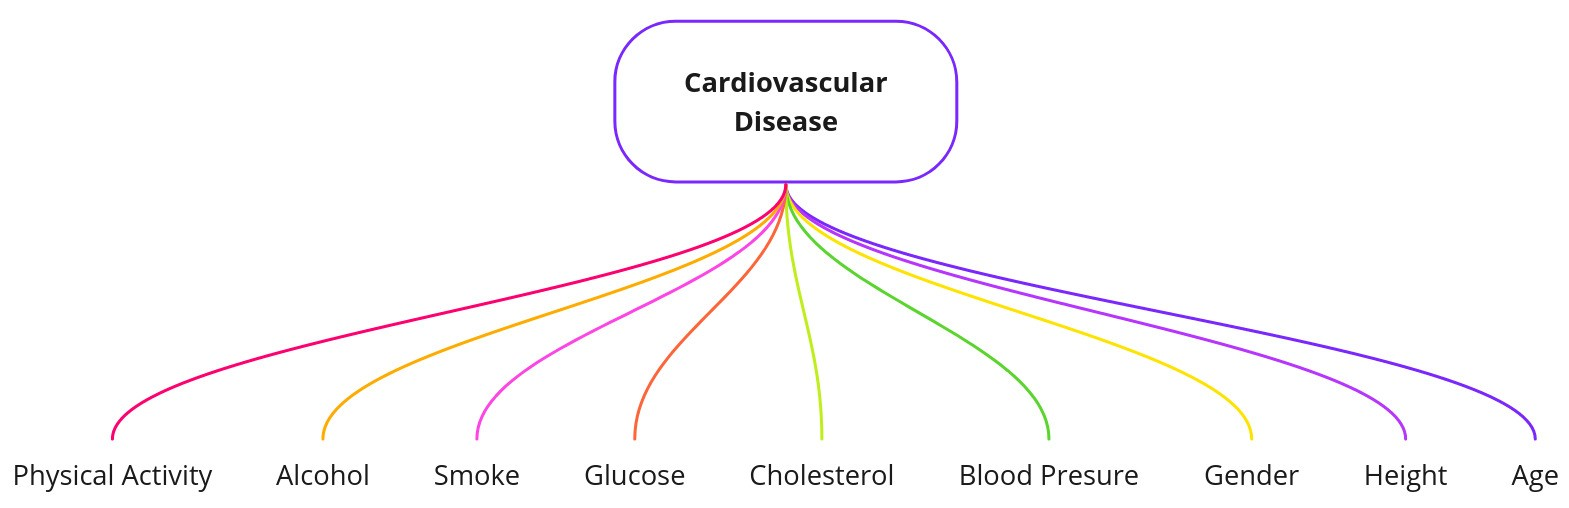

In [155]:
Image('img/mindmap.jpg')

## 2.2 Hypothesis List

### Based on the literature we can make the follow hypothesis:

### H1 - Older people have more cardiovascular diseases

### H2 - Smaller people have more cardiovascular diseases

### H3 - Men have more cardiovascular diseasess

### H4 - People with higher blood pressure have more cardiovascular diseases

### H5 - People with higher cholesterol have more cardiovascular diseases

### H6 - People with higher glucose have more cardiovascular diseases

### H7 - People who smoke have more cardiovascular diseases

### H8 - People who drink alcohol have more cardiovascular diseases

### H9 - Sedentary people have more cardiovascular diseasess

### Based on the hypothesis list some features can be created as BMI index, blood pressure aggregating ap_hi and ap_lo and a risk scale. Now we can add 2 more hypothesis.

### H10 - People with higher BMI have more cardiovascular diseases

### H11 - People with higher Risk Scale of CVD have more cardiovascular diseases

## 2.3 BMI

#### Body mass index (BMI) is a person’s weight in kilograms divided by the square of height in meters. 
#### BMI is an easy screening method for weight category—underweight, healthy weight, overweight, and obesity.

| BMI             | Weight Status           |
|-----------------|-------------------------|
| Below 18.5      | Underweight             |
| 18.5 - 24.9     | Normal or Health weight |
| 25.0 - 29.9     | Overweight              |
| 30.0 and above  | Obese                   |

In [156]:
df2 = df1.copy()

In [157]:
# Create a BMI Variable
df2['bmi'] = (df2['weight'] / ((df2['height']/100)**2)).round(1)

In [158]:
# Create a BMI Status Variable
df2['bmi_status'] = df2['bmi'].apply(lambda x: 'underweight' if x < 18.5 
                                             else 'normal' if (x >= 18.5) & (x <= 29.4)
                                             else 'overweight' if (x >= 25) & (x <= 29.9)
                                             else 'obese')

## 2.4 Blood Pressure

In [159]:
# Create Blod Pressure Variable
df2['blood_pressure'] = ['0' if (ap_hi <= 105) & (ap_lo <= 60)
                               else '1' if ((ap_hi > 105) & (ap_hi < 130)) & ((ap_lo > 60) & (ap_lo < 85))
                               else '2' if ((ap_hi >= 130) & (ap_hi < 140)) & ((ap_lo >= 85) & (ap_lo < 90))
                               else '3' if ((ap_hi >= 140) & (ap_hi < 160)) | ((ap_lo >= 90) & (ap_lo < 100))
                               else '4' if ((ap_hi >= 160) & (ap_hi < 180)) | ((ap_lo >= 100) & (ap_lo < 110))
                               else '5' 
                               for ap_hi, ap_lo in zip(df2['ap_hi'], df2['ap_lo'])]

In [160]:
# Create Blod Pressure Status Variable
df2['blood_pressure_status'] = ['low' if (ap_hi <= 105) & (ap_lo <= 60)
                               else 'normal' if ((ap_hi > 105) & (ap_hi < 130)) & ((ap_lo > 60) & (ap_lo < 85))
                               else 'high_normal' if ((ap_hi >= 130) & (ap_hi < 140)) & ((ap_lo >= 85) & (ap_lo < 90))
                               else 'hypertension_1' if ((ap_hi >= 140) & (ap_hi < 160)) | ((ap_lo >= 90) & (ap_lo < 100))
                               else 'hypertension_2' if ((ap_hi >= 160) & (ap_hi < 180)) | ((ap_lo >= 100) & (ap_lo < 110))
                               else 'hypertension_3' 
                               for ap_hi, ap_lo in zip(df2['ap_hi'], df2['ap_lo'])]

In [161]:
df2.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,0,1,2,3,4,8,9,12,13,14
age,50,55,51,48,47,60,60,61,48,54
gender,2,1,1,2,1,1,1,2,1,1
height,168,156,165,169,156,151,157,178,158,164
weight,62,85,64,82,56,67,93,95,71,68
ap_hi,110,140,130,150,100,120,130,130,110,110
ap_lo,80,90,70,100,60,80,80,90,70,60
cholesterol,1,3,3,1,1,2,3,3,1,1
gluc,1,1,1,1,1,2,1,3,1,1
smoke,0,0,0,0,0,0,0,0,0,0


## 2.5 Risk Scale

### The Risk Scale gives a summary of important varibales that can predict CVD based on the literature. This variables are: glucucose, cholesterol, bmi, somking, alcohol consumption and pshysical activity.

In [162]:
# Creating Risk Scale Variable rangind from 0 to 1
df2['risk_scale'] = df2['gluc'] + df2['cholesterol'] + df2['bmi'] + df2['smoke'] + df2['alco'] + df2['active']
mms = MinMaxScaler()
df2['risk_scale'] = mms.fit_transform( df2[['risk_scale']].values )

In [163]:
df2.describe().T 

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75000,50001.500000,74889.250000,99999.0
age,70000.0,52.840671,6.766774,29.0,48.00000,53.000000,58.000000,64.0
gender,70000.0,1.349571,0.476838,1.0,1.00000,1.000000,2.000000,2.0
height,70000.0,164.413743,7.922992,120.0,159.00000,165.000000,170.000000,207.0
weight,70000.0,74.235484,14.352685,40.0,65.00000,72.000000,82.000000,200.0
ap_hi,70000.0,126.895171,16.863638,60.0,120.00000,120.000000,140.000000,200.0
ap_lo,70000.0,81.272057,9.308658,40.0,80.00000,80.000000,90.000000,120.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00000,1.000000,2.000000,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00000,1.000000,1.000000,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00000,0.000000,0.000000,1.0


In [164]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     70000 non-null  int64  
 1   age                    70000 non-null  int32  
 2   gender                 70000 non-null  int64  
 3   height                 70000 non-null  int64  
 4   weight                 70000 non-null  float64
 5   ap_hi                  70000 non-null  int64  
 6   ap_lo                  70000 non-null  int64  
 7   cholesterol            70000 non-null  int64  
 8   gluc                   70000 non-null  int64  
 9   smoke                  70000 non-null  int64  
 10  alco                   70000 non-null  int64  
 11  active                 70000 non-null  int64  
 12  cardio                 70000 non-null  int64  
 13  bmi                    70000 non-null  float64
 14  bmi_status             70000 non-null  object 
 15  bl

In [165]:
# Trasform blood pressure in int64
df2['blood_pressure'] = df2['blood_pressure'].astype(int64)

In [166]:
# Check
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     70000 non-null  int64  
 1   age                    70000 non-null  int32  
 2   gender                 70000 non-null  int64  
 3   height                 70000 non-null  int64  
 4   weight                 70000 non-null  float64
 5   ap_hi                  70000 non-null  int64  
 6   ap_lo                  70000 non-null  int64  
 7   cholesterol            70000 non-null  int64  
 8   gluc                   70000 non-null  int64  
 9   smoke                  70000 non-null  int64  
 10  alco                   70000 non-null  int64  
 11  active                 70000 non-null  int64  
 12  cardio                 70000 non-null  int64  
 13  bmi                    70000 non-null  float64
 14  bmi_status             70000 non-null  object 
 15  bl

# 3.0 Variable Selection

In [167]:
df3 = df2.copy()

### 3.1 Split into numerical and binary variables

In [168]:
# Divide features in numerical, categorical and binary
num_var = df3[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'risk_scale' ]]
cat_var = df3[['cholesterol', 'gluc', 'blood_pressure']]
bin_var = df3[['gender', 'smoke', 'alco', 'active']]

# 4.0 Exploratory Data Analysis

In [169]:
df4 = df3.copy()

## 4.1 Descriptive Statistics after processing

In [170]:
# Numerical variables statistics
descriptive(num_var)

,attributes,mean,median,mode,std,min,max,range,skewness,kurtosis
0,age,52.840671,53.000000,55.000000,6.766725,29.0,64.0,35.0,-0.305744,-0.818981
1,height,164.413743,165.000000,165.000000,7.922935,120.0,207.0,87.0,0.025710,0.615596
2,weight,74.235484,72.000000,65.000000,14.352583,40.0,200.0,160.0,1.032817,2.590610
3,ap_hi,126.895171,120.000000,120.000000,16.863517,60.0,200.0,140.0,0.829987,1.281042
4,ap_lo,81.272057,80.000000,80.000000,9.308591,40.0,120.0,80.0,0.259634,1.260930
5,bmi,27.503073,26.400000,23.900000,5.287502,13.5,108.2,94.7,1.374181,4.649983
6,risk_scale,0.150869,0.138771,0.110169,0.059265,0.0,1.0,1.0,1.276726,3.839857


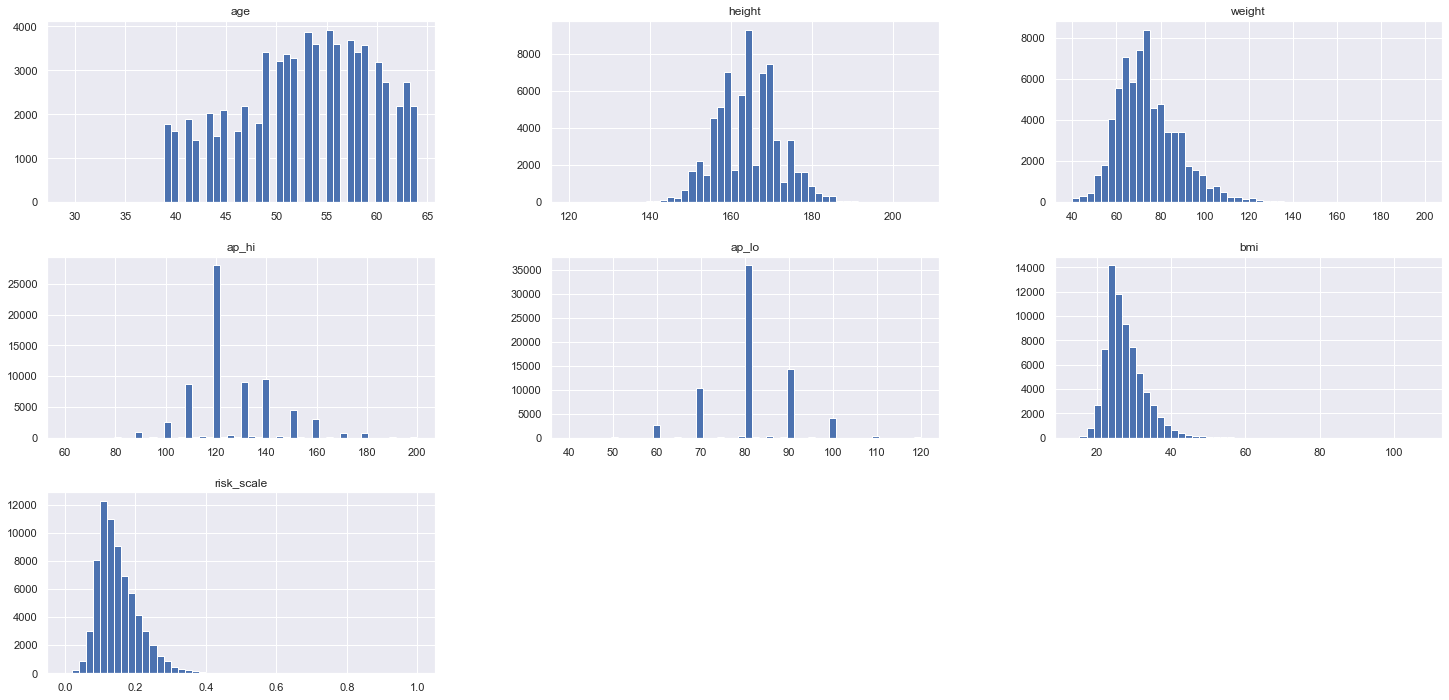

In [171]:
num_var.hist( bins = 50 );

## 4.2 Univariate Analysis

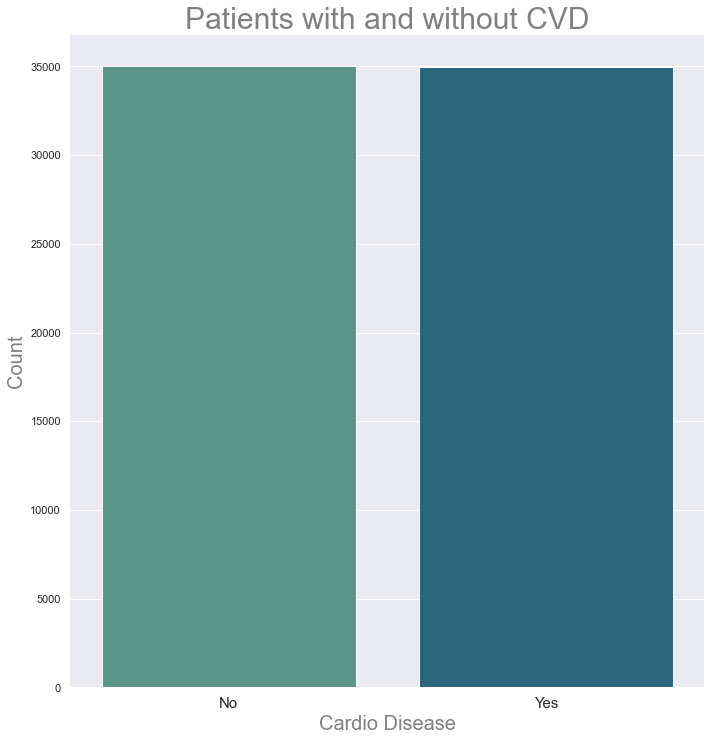

In [172]:
plt.subplot(121)
sns.countplot(df1['cardio'], palette='crest')
sns.set_style('whitegrid')
plt.title('Patients with and without CVD', size = 30, color = 'grey')
plt.xlabel('Cardio Disease', size = 20, color = 'grey')
plt.xticks(np.arange(2), labels=['No','Yes'], size = 15)
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.ylabel("Count", size = 20, color = 'grey');

#### People with and without cardio desease are almost equal (around 35.000).

## 4.3 Bivariate Analysis - Hypothesis Validation

### 4.3.1 H1 - Older people have more cardiovascular disease

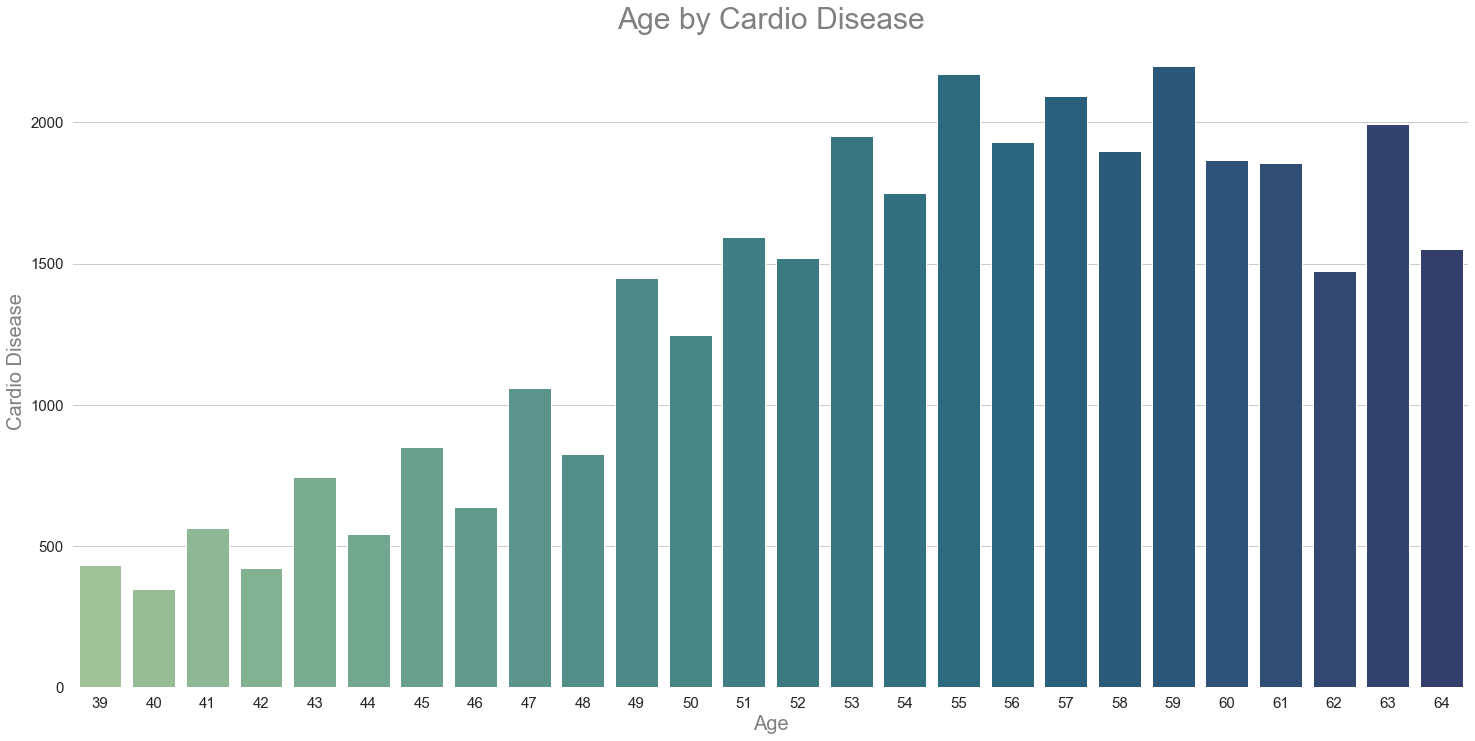

In [173]:
aux = df4[df4['cardio'] == 1 ][['age', 'cardio']].groupby('age').sum().reset_index()
sns.barplot( x = 'age', y = 'cardio', data = aux, palette = 'crest' );
plt.title('Age by Cardio Disease', size = 30, color = 'grey')
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Age", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

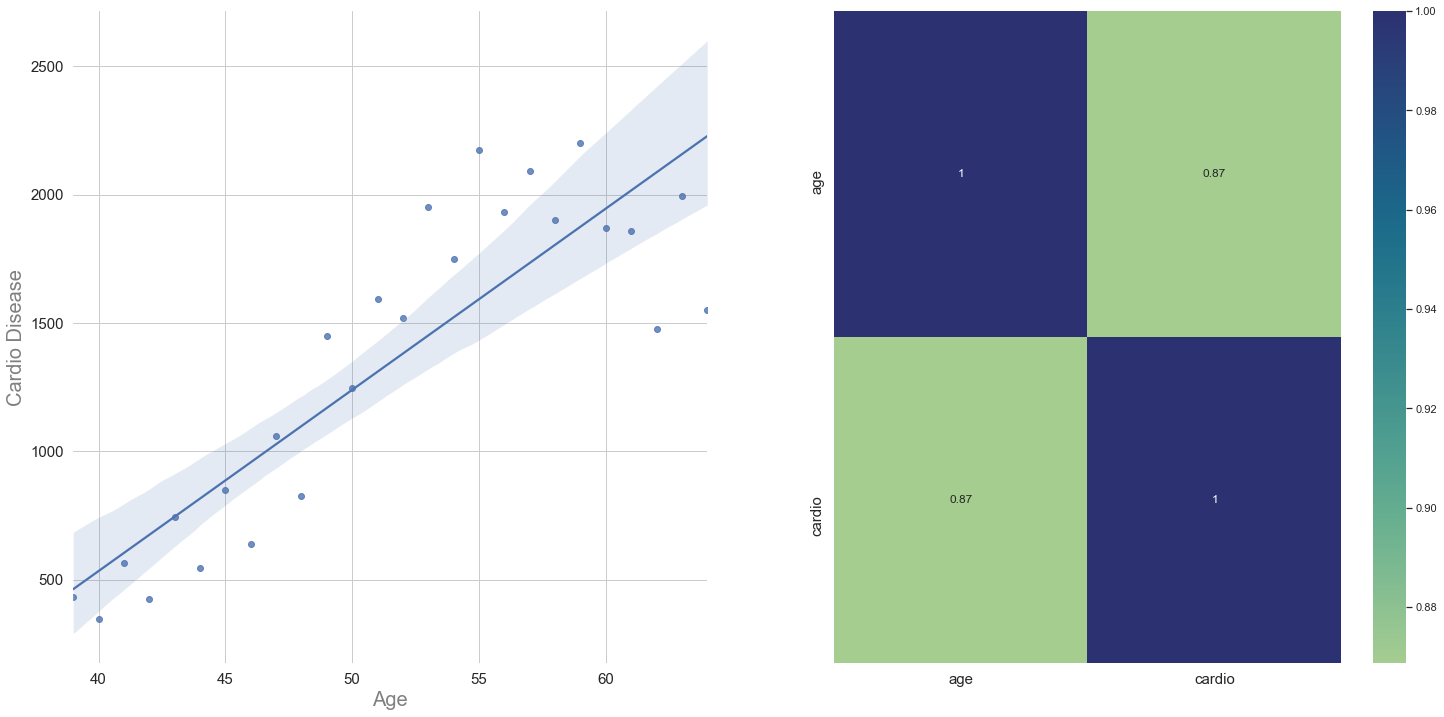

In [174]:
plt.subplot(121)
sns.regplot( x = 'age', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Age", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')

plt.subplot(122)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

### True hypothesis and the correlation is strong (0.87)

### 4.3.2 H2 - Smaller people have more cardiovascular diseases

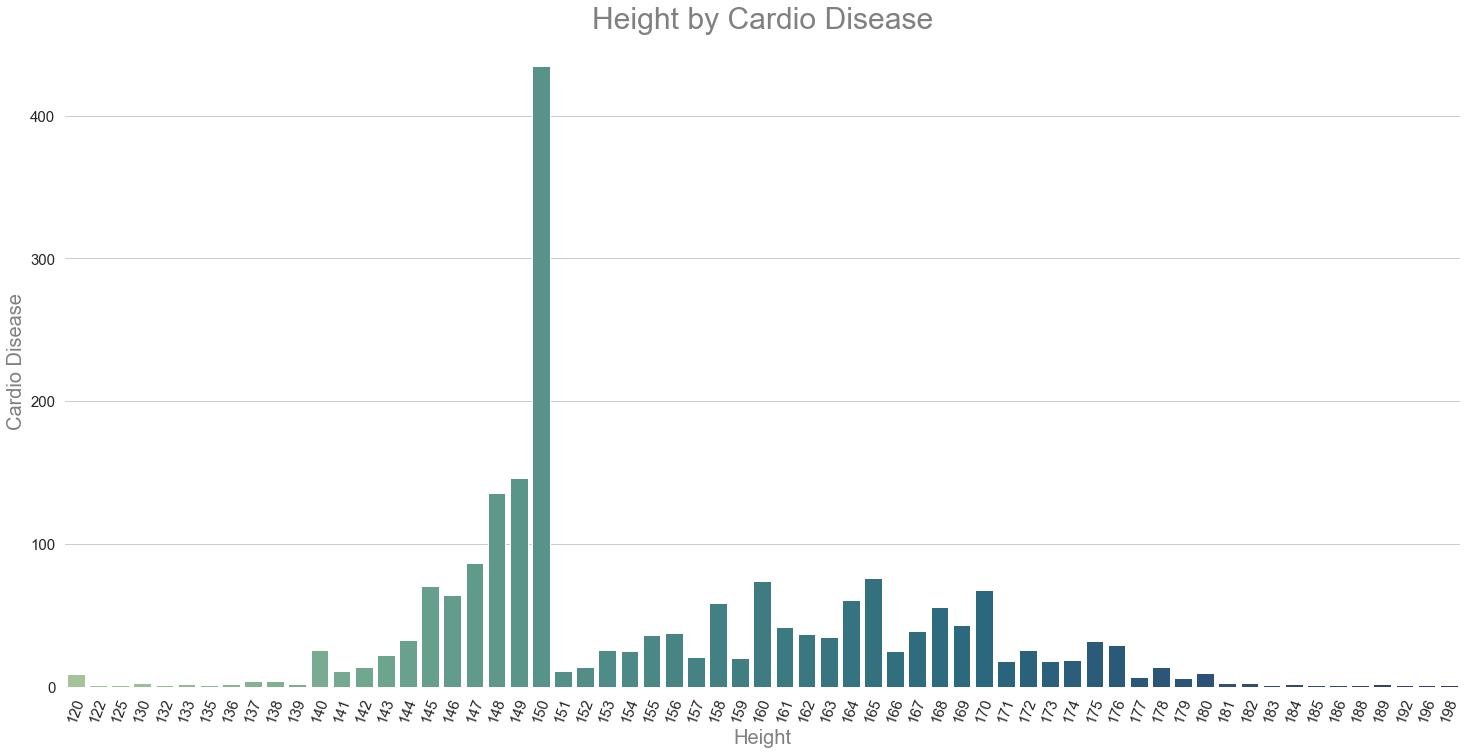

In [175]:
aux1 = df4[df4['height'] <= 150 ].sample(2000, replace=False) 
aux2 = df4[df4['height'] > 150 ].sample(2000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1][['height', 'cardio']].groupby('height').sum().reset_index()

sns.barplot( x = 'height', y = 'cardio', data = aux4, palette = 'crest' );
plt.title('Height by Cardio Disease', size = 30, color = 'grey')
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.xticks( rotation = 70, size = 15 )
plt.yticks(size = 15)
plt.xlabel("Height", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

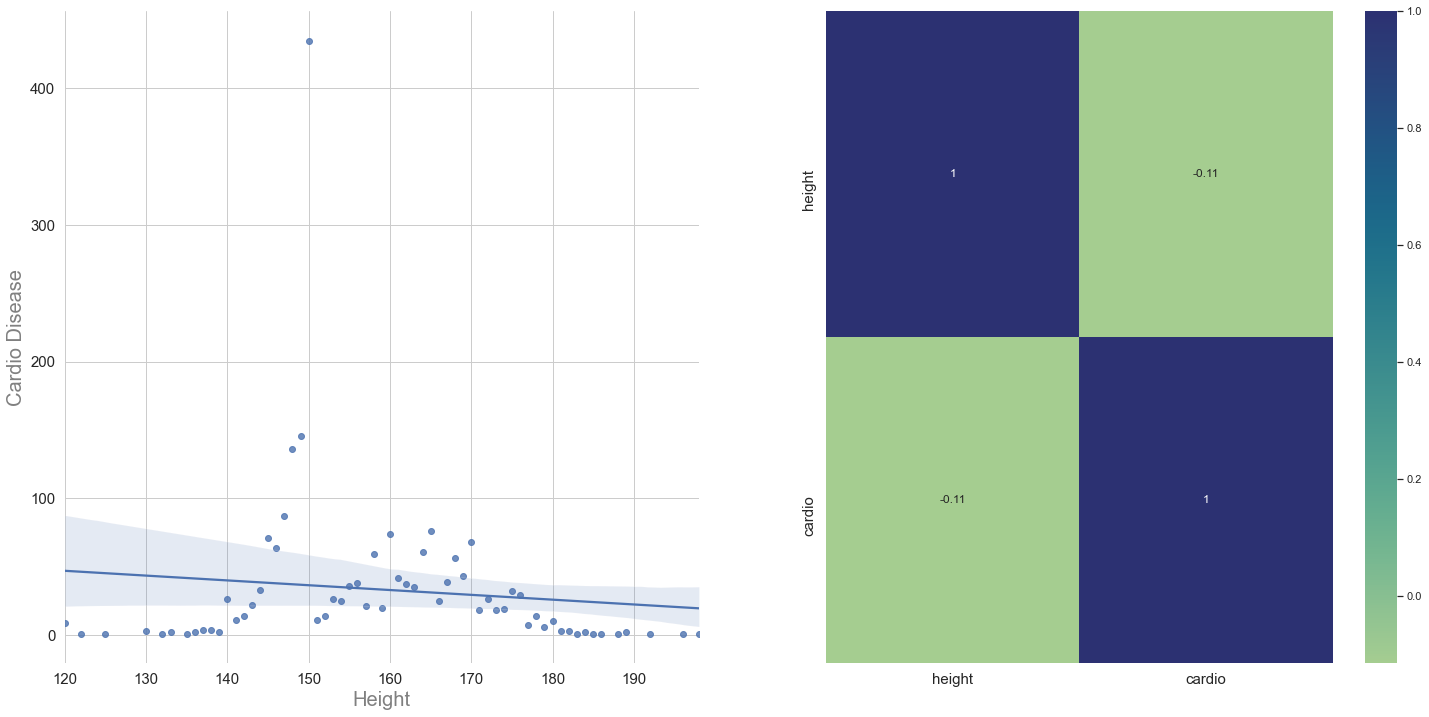

In [176]:
plt.subplot(121)
sns.regplot( x = 'height', y = 'cardio', data = aux4)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Height", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')

plt.subplot(122)
sns.heatmap( aux4.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

### True Hypothesis, but the correlation is low (-0.32)

### 4.3.3 H3 - Men have more cardiovascular diseasess

In [177]:
aux1 = df4[df4['gender'] == 1].sample(20000, replace=False) 
aux2 = df4[df4['gender'] == 2].sample(20000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1][['cardio', 'gender']].groupby(['gender']).sum().reset_index()
aux4

,gender,cardio
0,1,9873
1,2,10097


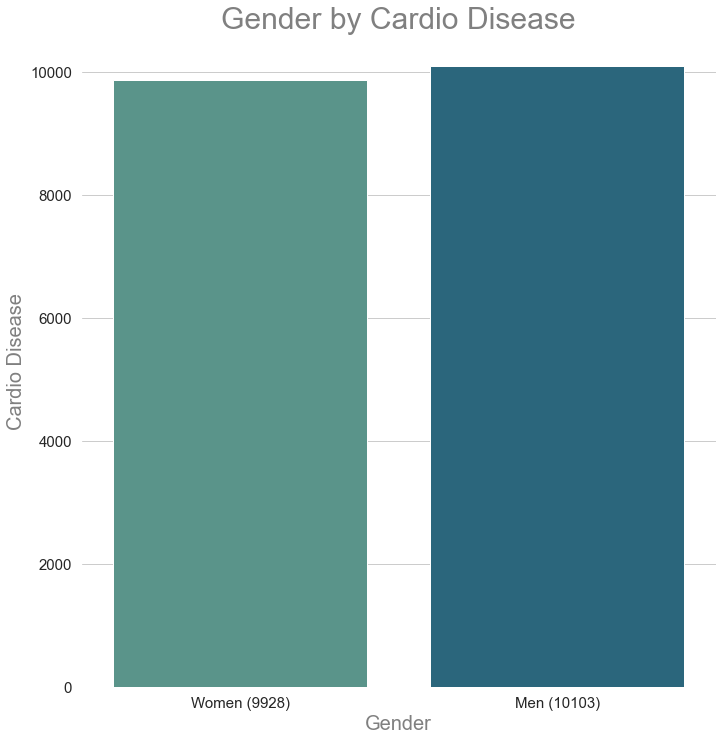

In [178]:
plt.subplot(121)
sns.barplot( x = 'gender', y = 'cardio', data = aux4, palette = 'crest' )
plt.title( 'Gender by Cardio Disease', size = 30, color = 'gray')
sns.despine(bottom = True, left = True)
plt.xlabel("Gender", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Women (9928)', 'Men (10103)'], size = 15)
plt.yticks(size = 15);

### True Hypothesis, but the difference is minimal

### 4.3.4 H4 - People with higher blood pressure have more cardiovascular diseases

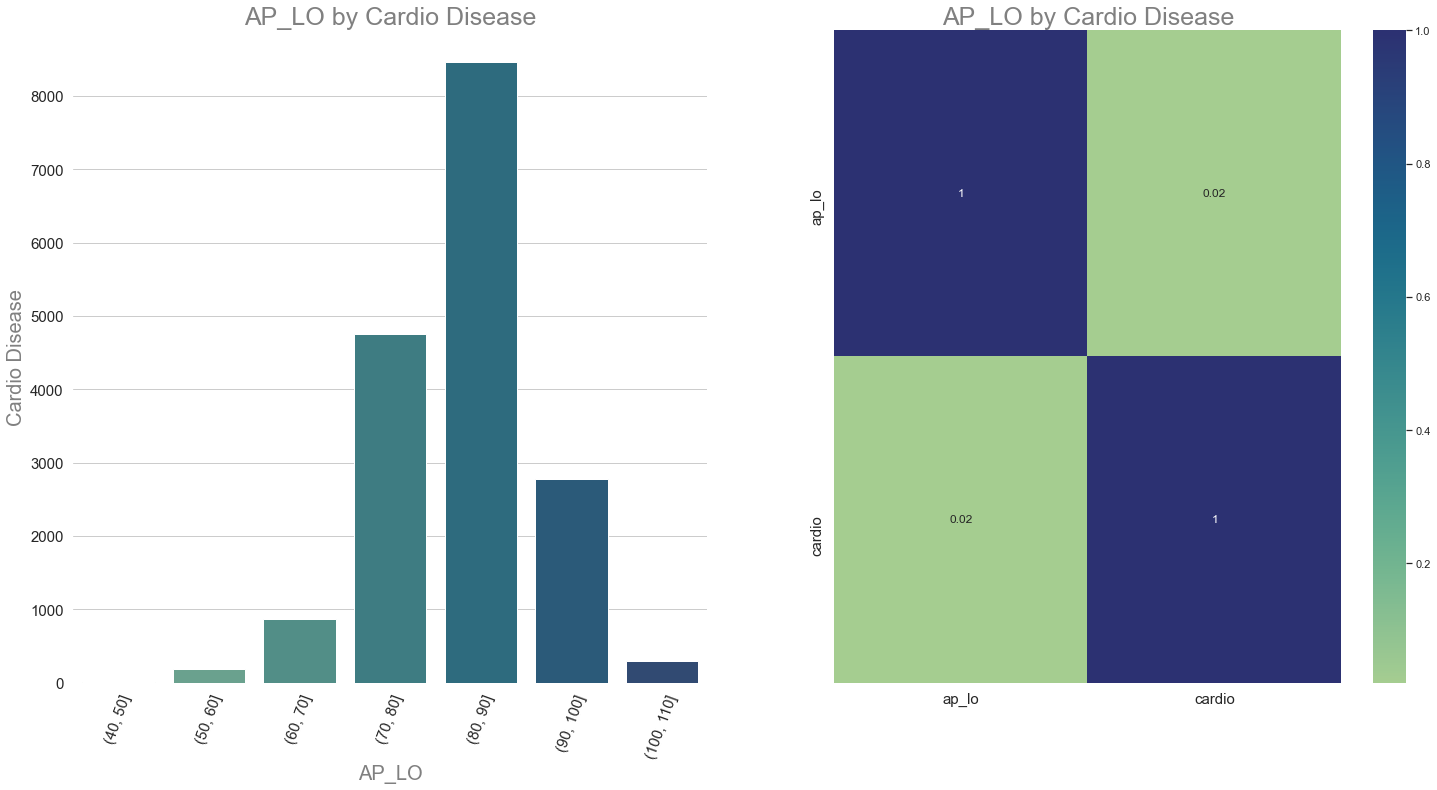

In [179]:
aux1 = df4[df4['ap_lo'] >= 90].sample(15000, replace=False) 
aux2 = df4[df4['ap_lo'] < 90].sample(15000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1]

aux5 = aux4[['cardio', 'ap_lo']].groupby(['ap_lo']).sum().reset_index()

bins = list( np.arange( 40, 120, 10) )
aux5['ap_lo_binned'] = pd.cut( aux5[ 'ap_lo' ], bins = bins )
aux6 = aux5[['cardio', 'ap_lo_binned']].groupby(['ap_lo_binned']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'ap_lo_binned', y = 'cardio', data = aux6, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'AP_LO by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("AP_LO", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(size = 15, rotation = 70)
plt.yticks(size = 15);

plt.subplot(122)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.title( 'AP_LO by Cardio Disease', size = 25, color = 'gray')
plt.xticks(size = 15)
plt.yticks(size = 15);

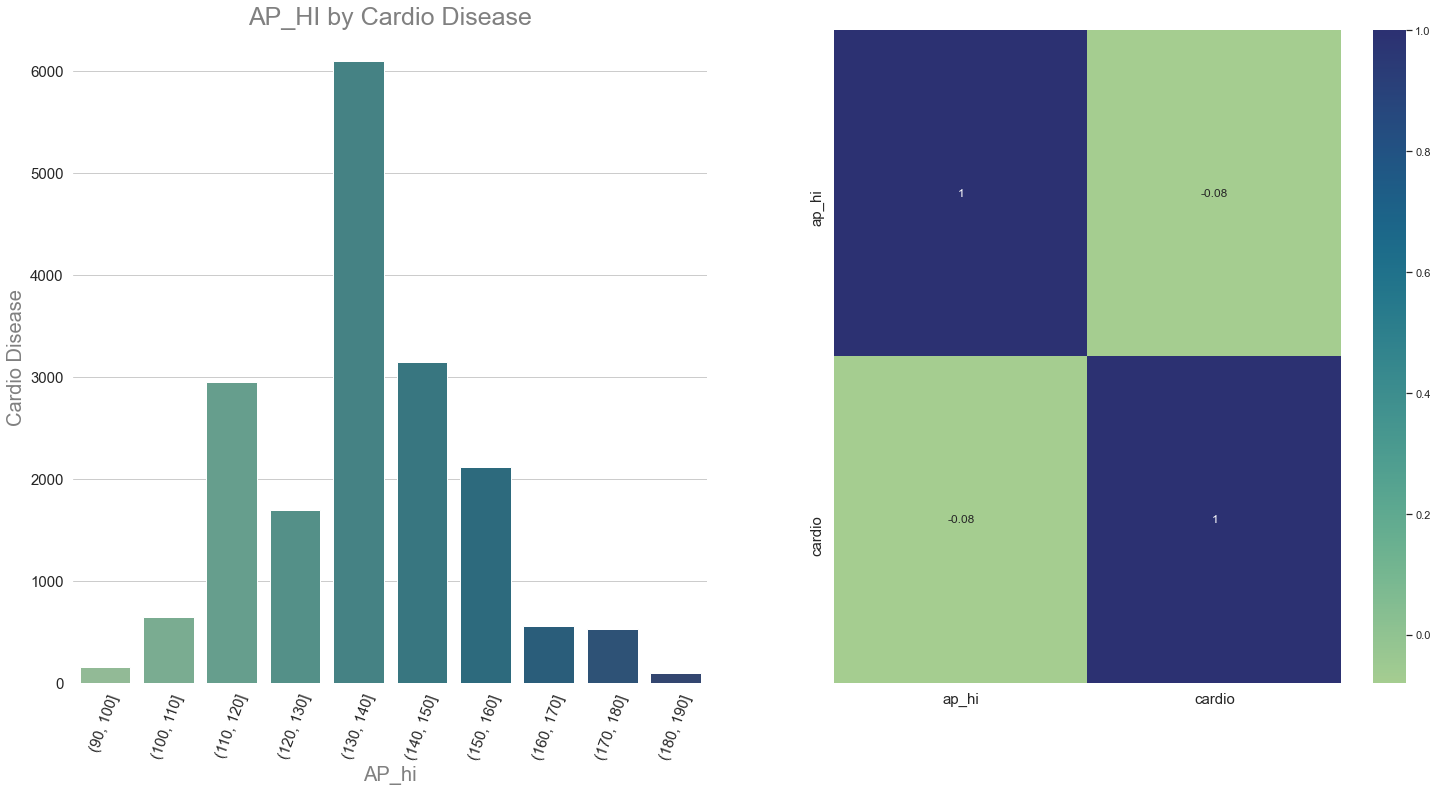

In [180]:
aux1 = df4[df4['ap_hi'] >= 140].sample(15000, replace=False) 
aux2 = df4[df4['ap_hi'] < 140].sample(15000, replace=False) 

aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio'] == 1]

aux5 = aux4[['cardio', 'ap_hi']].groupby(['ap_hi']).sum().reset_index()

bins = list( np.arange( 90, 200, 10) )
aux5['ap_hi_binned'] = pd.cut( aux5[ 'ap_hi' ], bins = bins )
aux6 = aux5[['cardio', 'ap_hi_binned']].groupby(['ap_hi_binned']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'ap_hi_binned', y = 'cardio', data = aux6, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'AP_HI by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("AP_hi", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(size = 15, rotation = 70)
plt.yticks(size = 15)

plt.subplot(122)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

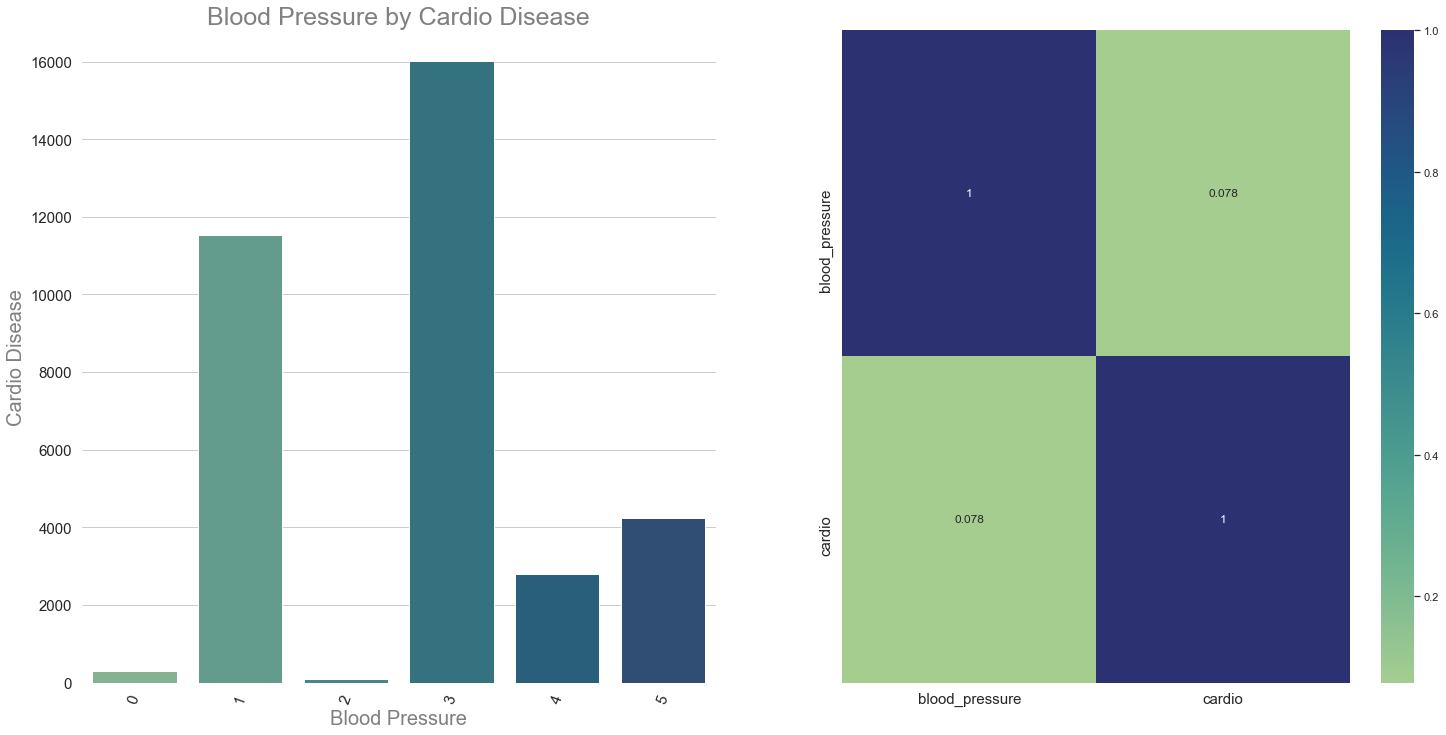

In [181]:
aux = df4[df4['cardio'] == 1][['cardio', 'blood_pressure']].groupby(['blood_pressure']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'blood_pressure', y = 'cardio', data = aux, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Blood Pressure by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Blood Pressure", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(size = 15, rotation = 70)
plt.yticks(size = 15)

plt.subplot(122)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

### False Hypothesis, the correlations are insignificant

### 4.3.5 H5 - People with higher cholesterol have more cardiovascular diseases

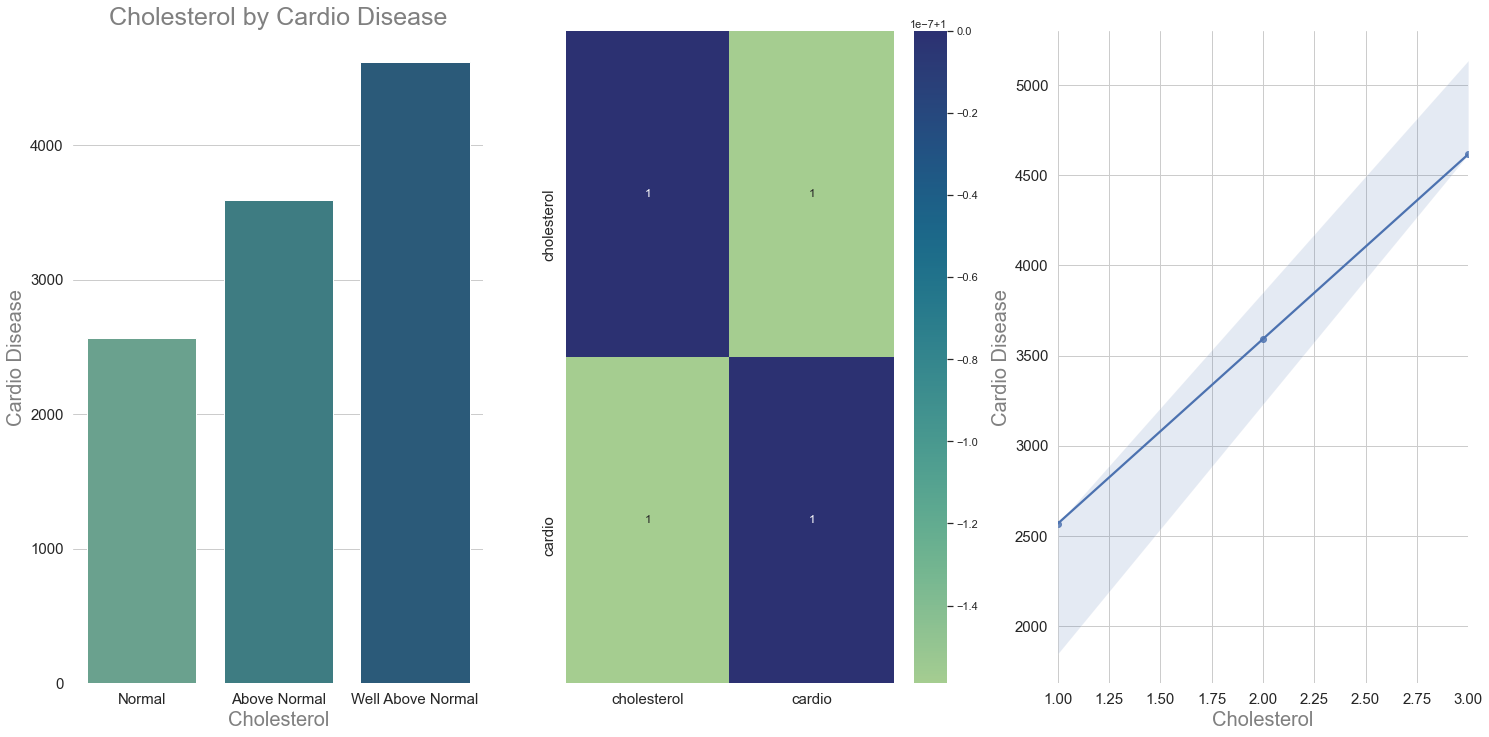

In [182]:
aux1 = df4[df4['cholesterol'] == 1].sample(6000, replace=False)
aux2 = df4[df4['cholesterol'] == 2].sample(6000, replace=False)
aux3 = df4[df4['cholesterol'] == 3].sample(6000, replace=False)
aux4 = pd.concat([aux1, aux2, aux3])
aux5 = aux4[aux4['cardio']==1][['cardio', 'cholesterol']].groupby(['cholesterol']).sum().reset_index()
        
plt.subplot(131)
sns.barplot( x = 'cholesterol', y = 'cardio', data = aux5, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Cholesterol by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Cholesterol", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['Normal', 'Above Normal', 'Well Above Normal'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(132)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(133)
sns.regplot( x = 'cholesterol', y = 'cardio', data = aux5)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Cholesterol", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

### True Hypothesis, the correlation is perfect (1)

### 4.3.6 H6 - People with higher glucose have more cardiovascular diseases

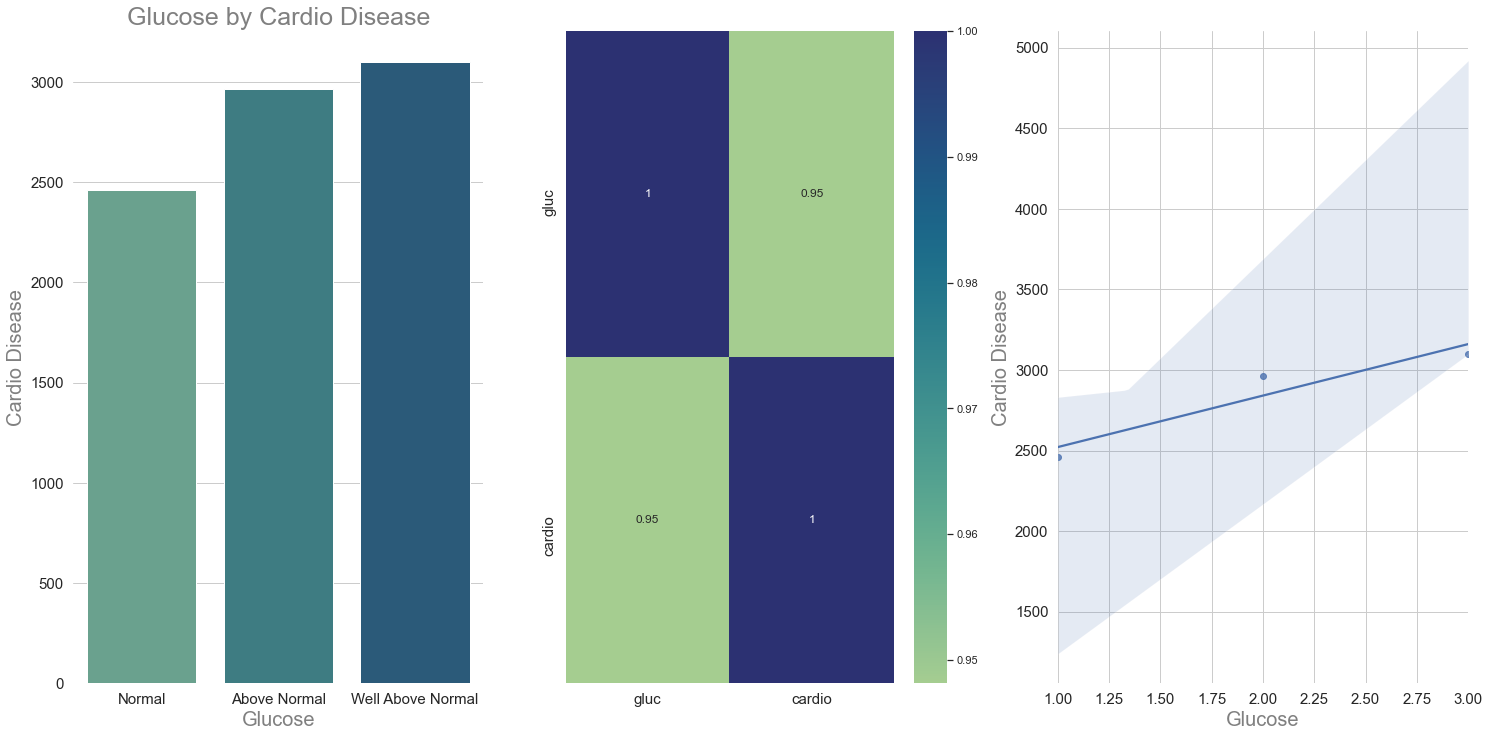

In [183]:
aux1 = df4[df4['gluc'] == 1].sample(5000, replace=False)
aux2 = df4[df4['gluc'] == 2].sample(5000, replace=False)
aux3 = df4[df4['gluc'] == 3].sample(5000, replace=False)
aux4 = pd.concat([aux1, aux2, aux3])
aux5 = aux4[aux4['cardio']==1][['cardio', 'gluc']].groupby(['gluc']).sum().reset_index()
        
plt.subplot(131)
sns.barplot( x = 'gluc', y = 'cardio', data = aux5, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Glucose by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Glucose", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['Normal', 'Above Normal', 'Well Above Normal'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(132)
sns.heatmap( aux5.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(133)
sns.regplot( x = 'gluc', y = 'cardio', data = aux5)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Glucose", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

### True Hypothesis, the correlation is very strong (0.95)

### 4.3.7 H7 - People who smoke have more cardiovascular diseases

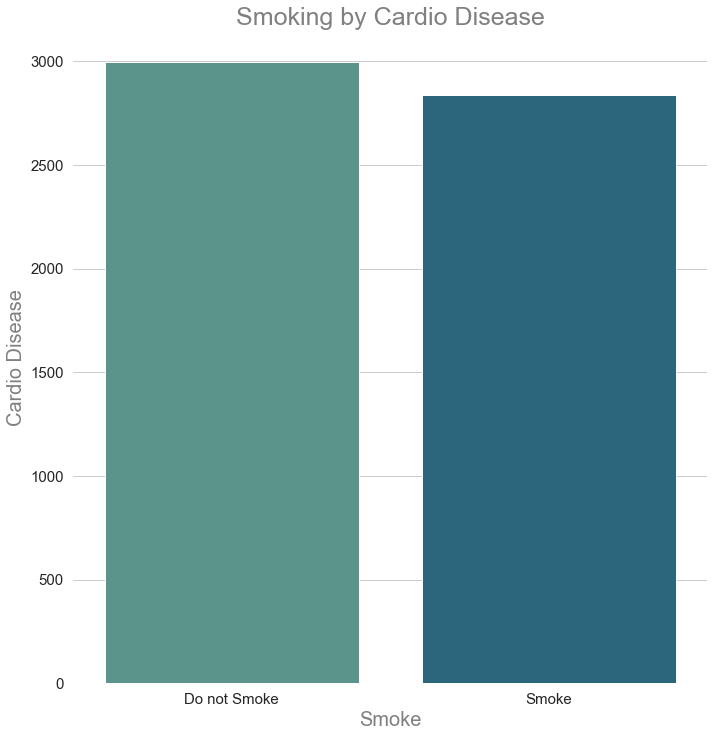

In [184]:
aux1 = df4[df4['smoke'] == 0].sample(6000, replace=False)
aux2 = df4[df4['smoke'] == 1].sample(6000, replace=False)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'smoke']].groupby(['smoke']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'smoke', y = 'cardio', data = aux4, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Smoking by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Smoke", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Do not Smoke', 'Smoke'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);


### False Hypothesis, but the difference is minimal

### 4.3.8 H8 - People who drink alcohol have more cardiovascular diseases

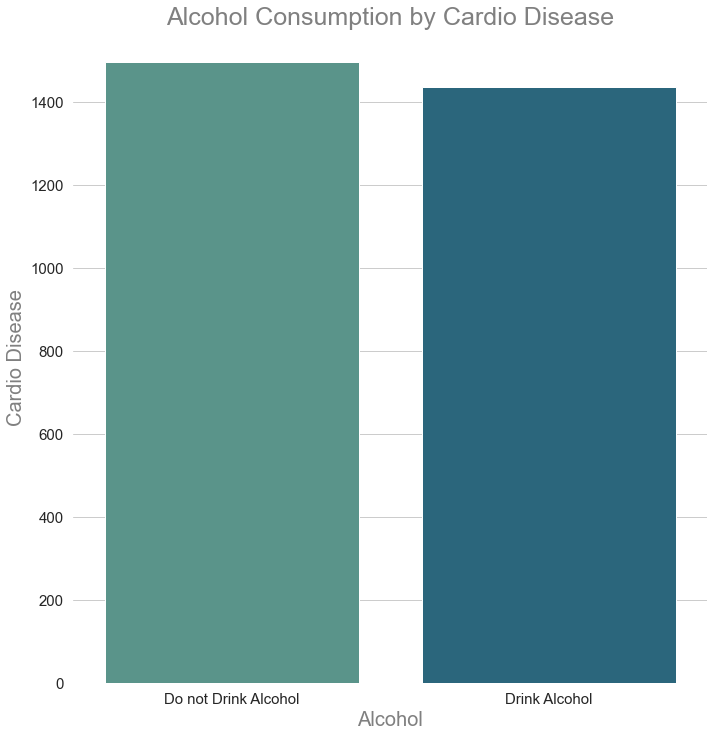

In [185]:
aux1 = df4[df4['alco'] == 0].sample(3000, replace=False)
aux2 = df4[df4['alco'] == 1].sample(3000, replace=False)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'alco']].groupby(['alco']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'alco', y = 'cardio', data = aux4, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Alcohol Consumption by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Alcohol", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Do not Drink Alcohol', 'Drink Alcohol'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

### False Hypothesis, but the difference is minimal

### 4.3.9 H9 - Sedentary people have more cardiovascular diseasess

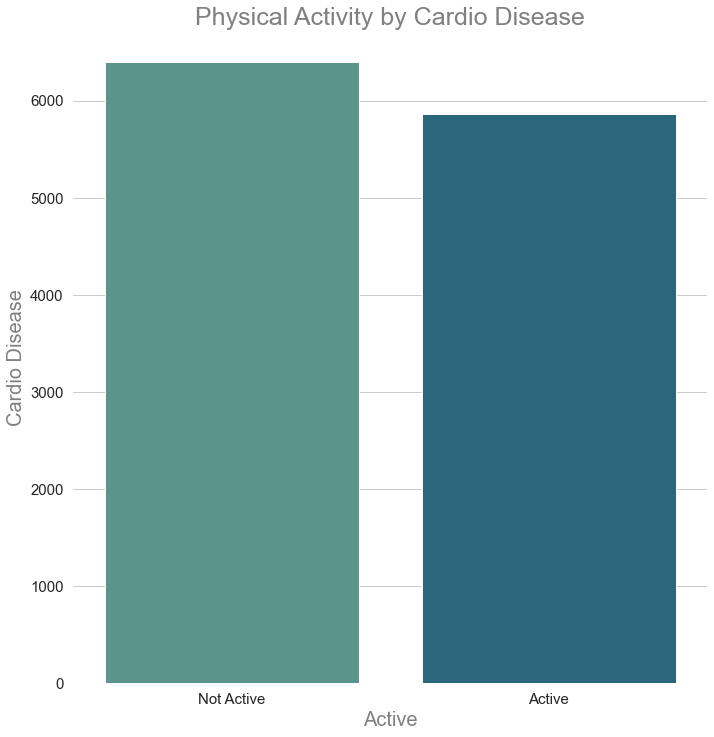

In [186]:
aux1 = df4[df4['active'] == 0].sample(12000, replace=False)
aux2 = df4[df4['active'] == 1].sample(12000, replace=False)
aux3 = pd.concat([aux1, aux2])
aux4 = aux3[aux3['cardio']==1][['cardio', 'active']].groupby(['active']).sum().reset_index()

plt.subplot(121)
sns.barplot( x = 'active', y = 'cardio', data = aux4, palette = 'crest' )
sns.despine( bottom = True, left = True)
plt.title( 'Physical Activity by Cardio Disease', size = 25, color = 'gray')
plt.xlabel("Active", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Not Active', 'Active'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

### False Hypothesis, but the difference is minimal

### 4.3.10 H10 - People with higher BMI have more cardiovascular diseases

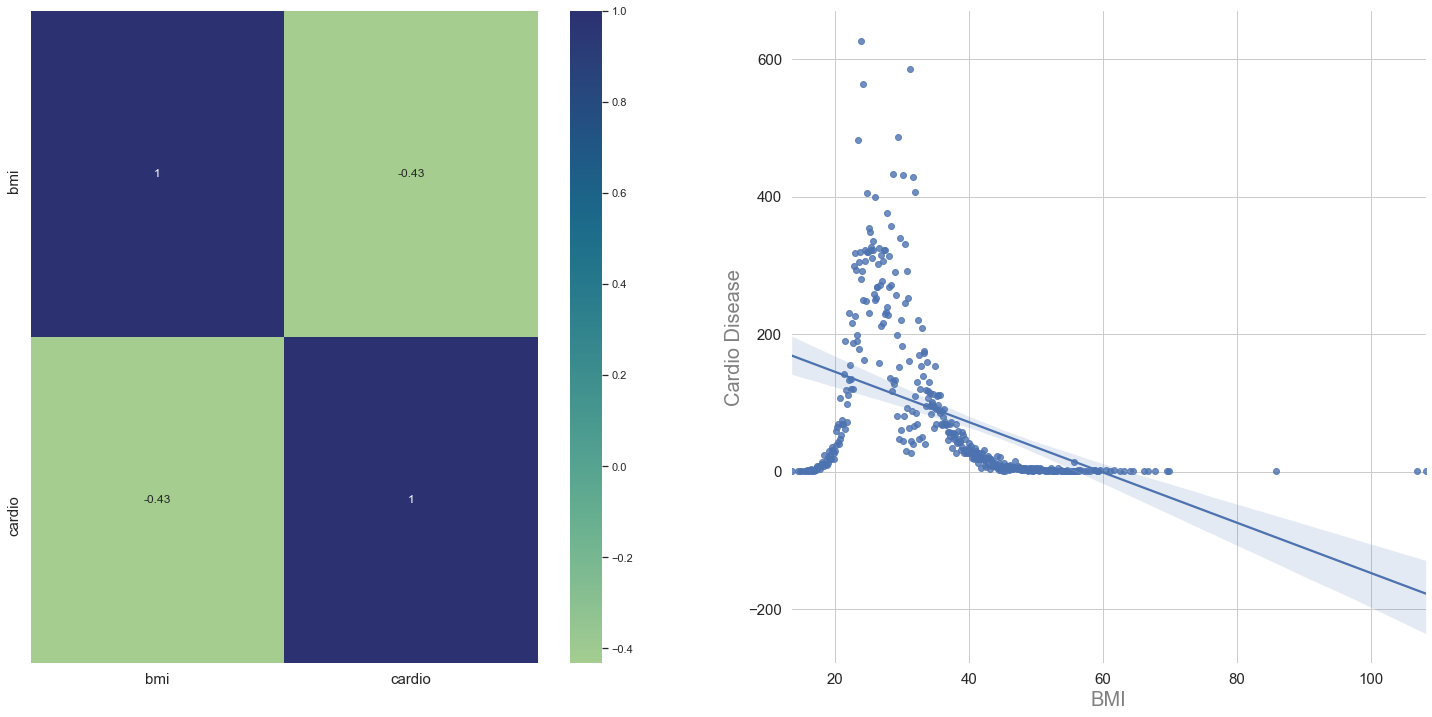

In [187]:
aux = df4[df4['cardio']==1][['cardio', 'bmi']].groupby(['bmi']).sum().reset_index()
        
plt.subplot(121)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(122)
sns.regplot( x = 'bmi', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("BMI", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

### False hypothesis, the correlation is moderate negative, but data is not linear

### 4.3.10 H11 People with higher Risk Scale of CVD have more cardiovascular diseases

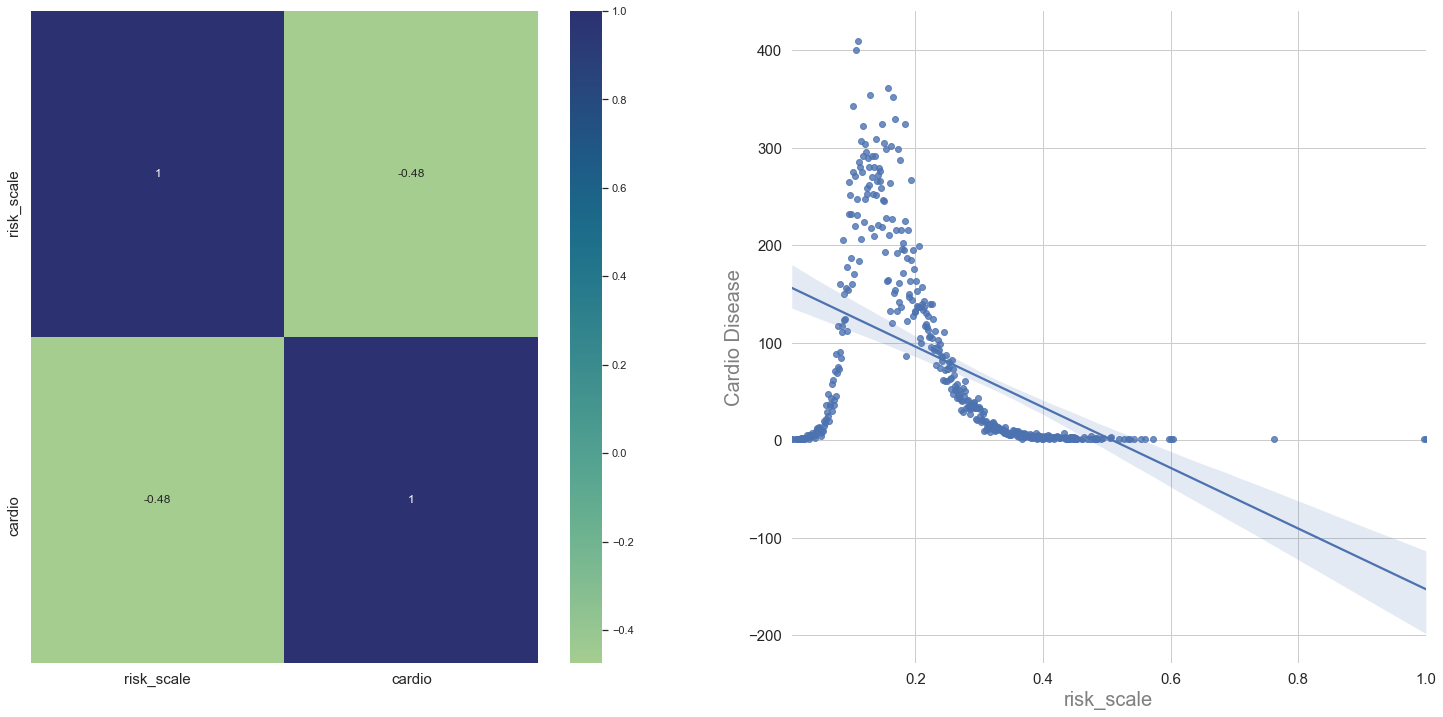

In [188]:
aux = df4[df4['cardio']==1][['cardio', 'risk_scale']].groupby(['risk_scale']).sum().reset_index()
        
plt.subplot(121)
sns.heatmap( aux.corr( method='pearson' ), annot=True, cmap="crest" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.subplot(122)
sns.regplot( x = 'risk_scale', y = 'cardio', data = aux)
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("risk_scale", size = 20, color = 'grey')
plt.ylabel("Cardio Disease", size = 20, color = 'grey');

### False hypothesis, the correlation is moderate negative, but data is not linear

## 4.3 Multivariate Analysis

### 4.3.1 Correltion among Numerical Variables

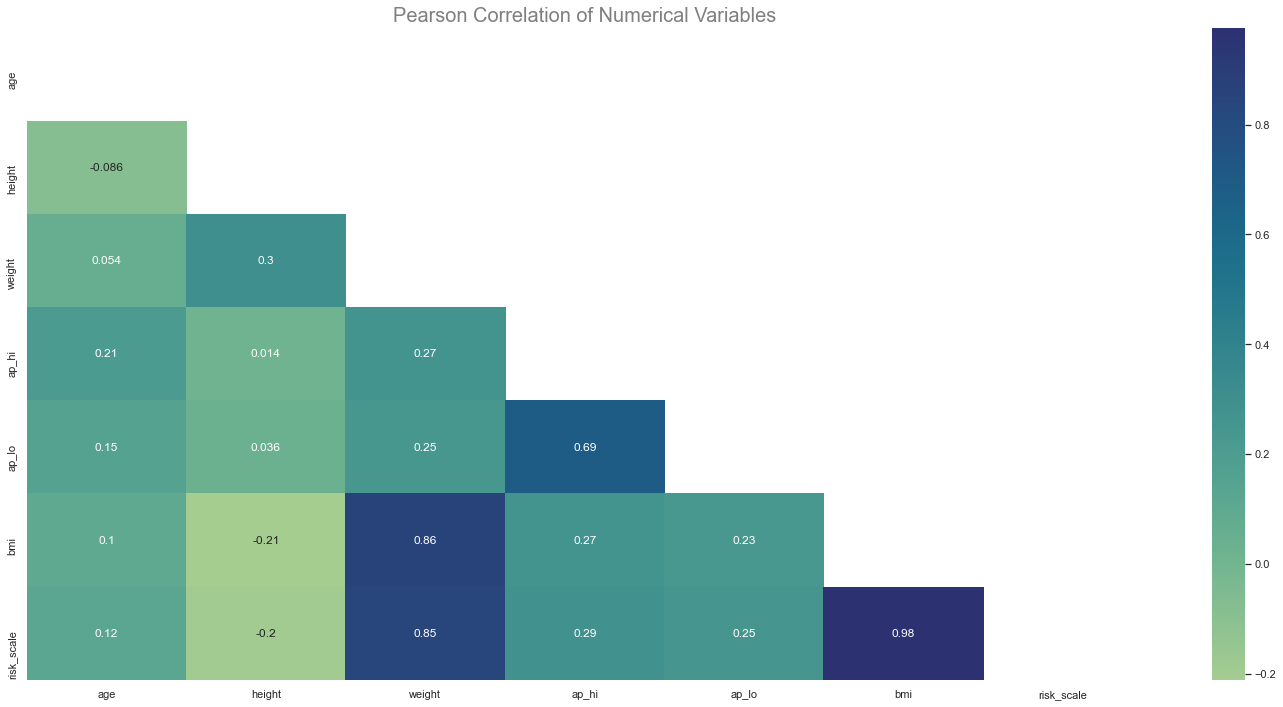

In [189]:
# Pearson Correlation
corr = num_var.corr( method = 'pearson' )

# Creating a with mask for the superior triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    # Creating the chart with mask
    ax = sns.heatmap(corr, mask=mask, annot = True, cmap = 'crest')
    plt.title("Pearson Correlation of Numerical Variables", size=20, color='gray');

### Key points:

#### The strongest positive correlations are between:

##### bmi x risk_scale (0.98),
##### weight x bmi (0.86)
##### weight x risk_scale (0.85)
##### ap_hi x ap_lo (0.69). 

### 4.3.2 Correlation among Numerical and Binary Variables

In [190]:
num_var.columns

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'risk_scale'], dtype='object')

In [191]:
bin_var.columns

Index(['gender', 'smoke', 'alco', 'active'], dtype='object')

In [192]:
#  All possible combinations
x1 = pointbiserialr(bin_var['gender'], num_var['age'])[0]
x2 = pointbiserialr(bin_var['gender'], num_var['height'])[0]
x3 = pointbiserialr(bin_var['gender'], num_var['weight'])[0]
x4 = pointbiserialr(bin_var['gender'], num_var['ap_hi'])[0]
x5 = pointbiserialr(bin_var['gender'], num_var['ap_lo'])[0]
x6 = pointbiserialr(bin_var['gender'], num_var['bmi'])[0]
x7 = pointbiserialr(bin_var['gender'], num_var['risk_scale'])[0]

x8 = pointbiserialr(bin_var['smoke'], num_var['age'])[0]
x9 = pointbiserialr(bin_var['smoke'], num_var['height'])[0]
x10 = pointbiserialr(bin_var['smoke'], num_var['weight'])[0]
x11 = pointbiserialr(bin_var['smoke'], num_var['ap_hi'])[0]
x12 = pointbiserialr(bin_var['smoke'], num_var['ap_lo'])[0]
x13 = pointbiserialr(bin_var['smoke'], num_var['bmi'])[0]
x14 = pointbiserialr(bin_var['smoke'], num_var['risk_scale'])[0]

x15 = pointbiserialr(bin_var['alco'], num_var['age'])[0]
x16 = pointbiserialr(bin_var['alco'], num_var['height'])[0]
x17 = pointbiserialr(bin_var['alco'], num_var['weight'])[0]
x18 = pointbiserialr(bin_var['alco'], num_var['ap_hi'])[0]
x19 = pointbiserialr(bin_var['alco'], num_var['ap_lo'])[0]
x20 = pointbiserialr(bin_var['alco'], num_var['bmi'])[0]
x21 = pointbiserialr(bin_var['alco'], num_var['risk_scale'])[0]

x22 = pointbiserialr(bin_var['active'], num_var['age'])[0]
x23 = pointbiserialr(bin_var['active'], num_var['height'])[0]
x24 = pointbiserialr(bin_var['active'], num_var['weight'])[0]
x25 = pointbiserialr(bin_var['active'], num_var['ap_hi'])[0]
x26 = pointbiserialr(bin_var['active'], num_var['ap_lo'])[0]
x27 = pointbiserialr(bin_var['active'], num_var['bmi'])[0]
x28 = pointbiserialr(bin_var['active'], num_var['risk_scale'])[0]

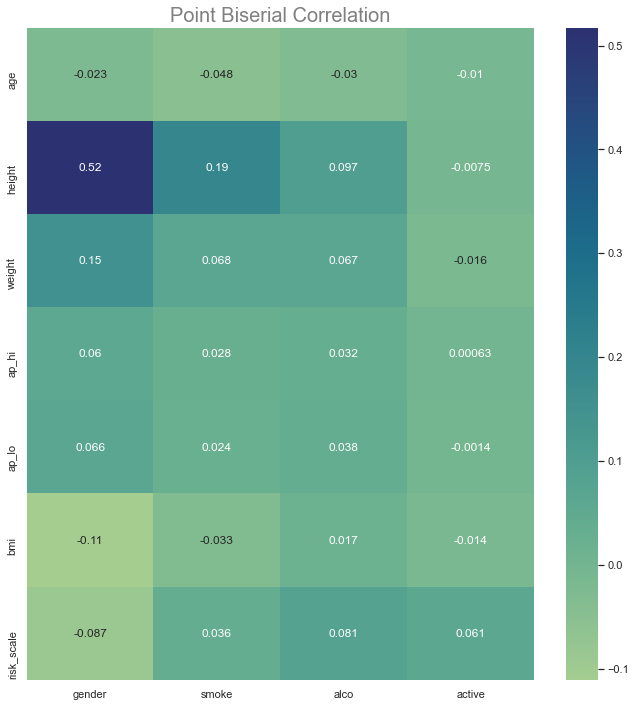

In [193]:
# Creating a DataFrame
dfx = pd.DataFrame({'gender':[x1, x2, x3, x4, x5, x6, x7],
                    'smoke':[x8, x9, x10, x11, x12, x13, x14],
                    'alco':[x15, x16, x17, x18, x19, x20, x21],
                    'active':[x22, x23, x24, x25, x26, x27, x28]})

# Sets the index equal to columns
dfx = dfx.set_index(num_var.columns)

# Heatmap
plt.subplot(121)
sns.heatmap(dfx, annot=True, annot_kws={"fontsize":12}, cmap='crest')
plt.title("Point Biserial Correlation", size=20, color='gray');

#### The only positive moderate correlation is betwenn gender x height (0.52)

## 4.3.3 Correlation among Categorical Variables

# 5.0 Data preparation

In [194]:
df5 = df4.copy()

In [195]:
df5.head().T

,0,1,2,3,4
id,0,1,2,3,4
age,50,55,51,48,47
gender,2,1,1,2,1
height,168,156,165,169,156
weight,62,85,64,82,56
ap_hi,110,140,130,150,100
ap_lo,80,90,70,100,60
cholesterol,1,3,3,1,1
gluc,1,1,1,1,1
smoke,0,0,0,0,0


In [196]:
# Drop Categorical columns
df5.drop(['bmi_status', 'blood_pressure_status'], axis=1, inplace=True)

## 5.1 Reescaling

There is a necessity of reeesclaing data because they vary a lot. It was chosen a Min Max Scaler.

In [197]:
mms = MinMaxScaler()

In [198]:
mms.fit(df5)

MinMaxScaler()

In [199]:
df5.head().T

,0,1,2,3,4
id,0.000000,1.000000,2.000000,3.000000,4.000000
age,50.000000,55.000000,51.000000,48.000000,47.000000
gender,2.000000,1.000000,1.000000,2.000000,1.000000
height,168.000000,156.000000,165.000000,169.000000,156.000000
weight,62.000000,85.000000,64.000000,82.000000,56.000000
ap_hi,110.000000,140.000000,130.000000,150.000000,100.000000
ap_lo,80.000000,90.000000,70.000000,100.000000,60.000000
cholesterol,1.000000,3.000000,3.000000,1.000000,1.000000
gluc,1.000000,1.000000,1.000000,1.000000,1.000000
smoke,0.000000,0.000000,0.000000,0.000000,0.000000


# 6.0 Feature Selection

In [200]:
df6 = df5.copy()

## 6.1 Split into Train and Test

In [201]:
X = df6.drop(['cardio'], axis=1).copy()
y = df6[['cardio']].copy()

In [202]:
X_train, X_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

## 6.2 Boruta

In [203]:
# Using Random Forest Classifier with all CPU cores
#rf = RandomForestClassifier(n_jobs=-1)
#extra = ExtraTreesClassifier(n_jobs=-1)

In [204]:
# Boruta using Extra Trees Classifier
#boruta = BorutaPy(extra, n_estimators='auto', verbose=False, random_state=23).fit(X_train.values, y_train.values.ravel())

# Columns Selected by Boruta using Extra Trees Classifier
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta

In [205]:
# Boruta using Random Forest Regressor
#boruta = BorutaPy(rf, n_estimators='auto', verbose=False, random_state=23).fit(X_train.values, y_train.values.ravel())

# Columns Selected by Boruta using Random Forest Regressor
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta

## 6.3 Boruta Features

In [210]:
bor_feat = df6[['age', 'weight', 'ap_hi', 'bmi', 'blood_pressure', 'risk_scale']]
bor_feat_full =  df6[['id', 'age', 'weight', 'ap_hi', 'bmi', 'blood_pressure', 'risk_scale', 'cardio']]

# 7.0 Machine Learning

In [211]:
X_train = bor_feat
X_test = bor_feat

## 7.1 Linear Regression

In [212]:
# Model
lr = LinearRegression().fit( X_train, y_train )

# Prediction
yhat_lr = lr.predict( X_test )
yhat_lr

ValueError: Found input variables with inconsistent numbers of samples: [70000, 56000]